In [72]:
# imports
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.spatial import distance
from scipy.stats import norm
from scipy.optimize import linear_sum_assignment
from tqdm.notebook import tqdm
from scipy.interpolate import interp2d
import cv2
import traceback 
import pickle
import warnings
warnings.filterwarnings('ignore')

# PARAMETERS
FRAME_RATE = 10
MINIMUM_TRACK_LENGTH = 10 # minimum number of frames a track must have to be considered
DIMENSION = [1944, 1944] # dimensions of the image
pose_markers = ['tip_of_head', 'antennaL', 'antennaR', 'petiole', 'ovipositor']
RECALCULATE = False

# make plots interactive
%matplotlib inline

# make plots dark
plt.style.use('dark_background')

In [73]:
# data loading
data_folder = '../data/vikram_raiding_data/sleap_prediction_round2-lowq'
raw_video_folder = '../data/vikram_raiding_data/sleap_prediction_round2-lowq/raw_video'
database = {}
for data_file in list(filter(lambda x: x.endswith('.csv'), os.listdir(data_folder))):
    database[data_file] = {}
    database[data_file]['tracking_data'] = pd.read_csv(os.path.join(data_folder, data_file))
    # swap the x and y coordinates
    columns = database[data_file]['tracking_data'].columns
    columns = list(filter(lambda x: x.endswith('.x') or x.endswith('.y'), columns))
    columns = np.unique(list(map(lambda x: x.split('.')[0], columns)))
    for column in columns:
        x = database[data_file]['tracking_data'][column + '.x'].values
        y = database[data_file]['tracking_data'][column + '.y'].values
        database[data_file]['tracking_data'][column + '.x'] = y
        database[data_file]['tracking_data'][column + '.y'] = x

## Data Cleaning

In [74]:
def get_tracks(tracking_data):
    '''
    Get all unique tracks from the data, and return them as a list of dataframes
    '''
    tracks = tracking_data['track'].unique()
    return [tracking_data[tracking_data['track'] == track] for track in tracks]

def simple_interpolate_track(track, pose_markers):
    '''
    Interpolate the track to fill in missing values
    '''
    # make a copy of the track
    track = track.copy().reset_index(drop=True)
    for marker in pose_markers:
        track.loc[:, marker + '.x'] = track[marker + '.x'].infer_objects(copy=False).interpolate()
        track.loc[:, marker + '.y'] = track[marker + '.y'].infer_objects(copy=False).interpolate()
    # fill each end with the first and last values
    for marker in pose_markers:
        track.loc[:, marker + '.x'] = track[marker + '.x'].fillna(method='bfill').fillna(method='ffill')
        track.loc[:, marker + '.y'] = track[marker + '.y'].fillna(method='bfill').fillna(method='ffill')
    return track

def calculate_time(track):
    '''
    Calculate the time at each frame in the track
    '''
    # make a copy of the track
    track = track.copy().reset_index(drop=True)
    # calculate the time
    track.loc[:, 'time'] = track['frame_idx'] / FRAME_RATE
    return track

def calculate_centroid(track, pose_markers): 
    '''
    Calculate the centroid position at each frame in the track
    '''
    # make a copy of the track
    track = track.copy().reset_index(drop=True)
    centroid_x = np.nanmean([track[marker + '.x'] for marker in pose_markers], axis=0)
    centroid_y = np.nanmean([track[marker + '.y'] for marker in pose_markers], axis=0)
    # add to the track
    track.loc[:, 'centroid.x'] = centroid_x
    track.loc[:, 'centroid.y'] = centroid_y
    return track

def calculate_velocity(track, pose_markers=None):
    '''
    Calculate the velocity at each frame in the track
    '''
    assert all([col in track.columns for col in ['centroid.x', 'centroid.y']]), 'Track does not have centroid position'
    if pose_markers is not None:
        assert all([col in track.columns for col in [pm + '.x' for pm in pose_markers] + [pm + '.y' for pm in pose_markers]]), 'Track does not have pose markers'

    # make sure the track is long enough
    if len(track) < 2:
        return None

    # make a copy of the track
    track = track.copy().reset_index(drop=True)
    # calculate the velocity
    velocity_x = np.diff(track['centroid.x'])
    velocity_y = np.diff(track['centroid.y'])
    velocity = np.sqrt(velocity_x**2 + velocity_y**2)
    delta_t = np.diff(track['time'])
    velocity = np.where(delta_t > 0, velocity / delta_t, np.nan)
    # add to the track
    track.loc[0, 'velocity'] = 0
    track.loc[1:, 'velocity'] = velocity
    # calculate the angle
    angle = np.arctan2(velocity_y, velocity_x)
    track.loc[0, 'angle'] = 0
    track.loc[1:, 'angle'] = angle

    # calculate the velocity of each pose marker
    if pose_markers is not None:
        for marker in pose_markers:
            velocity_x = np.diff(track[marker + '.x'])
            velocity_y = np.diff(track[marker + '.y'])
            velocity = np.sqrt(velocity_x**2 + velocity_y**2)
            delta_t = np.diff(track['frame_idx'])/FRAME_RATE
            velocity = velocity / delta_t
            # add to the track
            track.loc[0, marker + '.velocity'] = 0
            track.loc[1:, marker + '.velocity'] = velocity
            # calculate the angle
            angle = np.arctan2(velocity_y, velocity_x)
            track.loc[0, marker + '.angle'] = 0
            track.loc[1:, marker + '.angle'] = angle

    # remove the last frame
    track = track.iloc[:-1]
    return track

def calculate_posture_distances(track, pose_markers):
    '''
    Calculate the distance matrix between all pairs of pose markers
    '''
    # make a copy of the track
    track = track.copy().reset_index(drop=True)
    # calculate the distance matrix
    dist_matrix = np.zeros((len(track), len(pose_markers), len(pose_markers)))
    for i, marker1 in enumerate(pose_markers):
        for j, marker2 in enumerate(pose_markers):
            if i >= j:
                continue
            dist_matrix[:, i, j] = np.sqrt((track[marker1 + '.x'] - track[marker2 + '.x'])**2 + (track[marker1 + '.y'] - track[marker2 + '.y'])**2)
    # add to the track
    for i, marker1 in enumerate(pose_markers):
        for j, marker2 in enumerate(pose_markers):
            if i >= j:
                continue
            track.loc[:, marker1 + '.' + marker2 + '.pose_distance'] = dist_matrix[:, i, j]
    return track

def uniform_interpolate_track(track):
    '''
    Interpolate the track to fill in missing values including missing frames
    '''
    # make a copy of the track
    track = track.copy().reset_index(drop=True)
    # get smallest and largest frame index
    min_frame_idx = track['frame_idx'].min()
    max_frame_idx = track['frame_idx'].max()
    # add missing frames
    for frame_idx in range(min_frame_idx, max_frame_idx):
        if frame_idx not in track['frame_idx'].values:
            # add a new row using concatenation
            new_row = pd.DataFrame({'frame_idx': [frame_idx]})
            track = pd.concat([track, new_row], ignore_index=True)
    # sort by frame index
    track = track.sort_values('frame_idx').reset_index(drop=True)
    # interpolate all columns
    for col in track.columns:
        if col == 'frame_idx':
            continue
        track.loc[:, col] = track[col].infer_objects(copy=False).interpolate()
    # fill each end with the first and last values
    for col in track.columns:
        if col == 'frame_idx':
            continue
        track.loc[:, col] = track[col].fillna(method='bfill').fillna(method='ffill')
    return track

In [75]:
RECALCULATE=False

In [76]:
# check if cleaned data pickle exists
if os.path.exists('../data/vikram_raiding_data/sleap_prediction_round2-lowq/cleaned_database.pkl') and not RECALCULATE:
    with open('../data/vikram_raiding_data/sleap_prediction_round2-lowq/cleaned_database.pkl', 'rb') as f:
        database = pickle.load(f)
    print('Loaded cleaned data from pickle')
else:
    # for each video, get all tracks
    for data_file in database.keys():
        database[data_file]['tracks'] = get_tracks(database[data_file]['tracking_data'])
    
    # split videos with more than 1 frame gap
    for data_file in database.keys():
        update_tracks = []
        for track in database[data_file]['tracks']:
            # sort the track by frame index
            track = track.sort_values('frame_idx').reset_index(drop=True)
            split_points = np.where(np.diff(track['frame_idx']) >= 2)[0]
            # add split points where the there is no difference
            split_points = np.concatenate((split_points, np.where(np.diff(track['frame_idx']) == 0)[0]))+1
            # sort the split points
            split_points = np.sort(split_points)
            split_points = np.concatenate(([0], split_points, [len(track)]))
            if len(split_points) == 2:
                # interpolate the track
                track = uniform_interpolate_track(track)
                update_tracks.append(track)
            else:
                for i in range(len(split_points) - 1):
                    segment = track.iloc[split_points[i]:split_points[i+1]].copy().reset_index(drop=True)
                    # skip if the segment is empty
                    if len(segment) < 1:
                        continue
                    # interpolate the segment
                    segment = uniform_interpolate_track(segment)
                    update_tracks.append(segment)
        database[data_file]['tracks'] = update_tracks
        
    # for each video, calculate the centroid and velocity for each track
    for data_file in database.keys():
        update_tracks = []
        for track in database[data_file]['tracks']:
            track = calculate_time(track)
            track = calculate_centroid(track, pose_markers)
            track = calculate_velocity(track, pose_markers)
            # if the track is none, skip
            if track is None:
                continue
            track = calculate_posture_distances(track, pose_markers)
            update_tracks.append(track)
        database[data_file]['tracks'] = update_tracks

    # for each video, get the distribution of velocities, pose distances to calculate the threshold
    for data_file in database.keys():
        velocities = []
        for track in database[data_file]['tracks']:
            velocities.extend(track['velocity'].values)
        # get the 95th percentile of the velocities
        database[data_file]['velocity_threshold'] = np.nanpercentile(velocities, 95)
        print(f'{data_file}: {database[data_file]["velocity_threshold"]}')
        # get all keys with "pose_distance" in the name
        pose_distance_keys = list(filter(lambda x: 'pose_distance' in x, database[data_file]['tracks'][0].columns))
        for key in pose_distance_keys:
            pose_distances = []
            for track in database[data_file]['tracks']:
                pose_distances.extend(track[key].values)
            # get the 95th percentile of the pose distances
            database[data_file][key + '_threshold'] = np.nanmedian(pose_distances)*1.3
            print(f'{data_file}: {key}: {database[data_file][key + "_threshold"]}')

    # for each video, clean the tracks by splitting them at high velocity points
    for data_file in database.keys():
        update_tracks = []
        segment_number = 0
        print(f'{data_file}: cleaning tracks; {len(database[data_file]["tracks"])} tracks found')
        for track in database[data_file]['tracks']:
            # split the track at high velocity points
            split_points = np.where(track['velocity'] > database[data_file]['velocity_threshold'])[0]
            if len(split_points) == 0:
                segment = track.copy().reset_index(drop=True)
                segment.loc[:, 'segment'] = segment_number
                segment_number += 1
                update_tracks.append(segment)
            else:
                split_points = np.concatenate(([0], split_points, [len(track)]))
                for i in range(len(split_points) - 1):
                    # get the track segment
                    segment = track.iloc[split_points[i]:split_points[i+1]].copy().reset_index(drop=True)
                    # recalculate the velocity and pose distances
                    segment = calculate_velocity(segment, pose_markers)
                    # if the segment is none, skip
                    if segment is None:
                        continue
                    # add the segment number
                    segment.loc[:, 'segment'] = segment_number
                    segment_number += 1
                    update_tracks.append(segment)
        print(f'{data_file}: {len(update_tracks)} tracks after cleaning')
        database[data_file]['tracks'] = update_tracks

    # for frames whare the pose distances are too high, remove them
    for data_file in database.keys():
        update_tracks = []
        # get names of all pose distance keys
        pose_distance_keys = list(filter(lambda x: 'pose_distance' in x, database[data_file]['tracks'][0].columns))
        for track in database[data_file]['tracks']:
            # recalculate the pose distances
            track = calculate_posture_distances(track, pose_markers)
            # add a pose flag and fill frames with pose flag 1 with NaN for all markers involved
            track.loc[:, 'pose_flag'] = 0
            for key in pose_distance_keys:
                affected_locs = track[key] > database[data_file][key + '_threshold']
                track.loc[affected_locs, 'pose_flag'] = 1
                if sum(affected_locs) > 0:
                    markers_involved = key.split('.')[:2]
                    for marker in markers_involved:
                        track.loc[affected_locs, marker + '.x'] = np.nan
                        track.loc[affected_locs, marker + '.y'] = np.nan
            # interpolate the track
            track = uniform_interpolate_track(track)
            update_tracks.append(track)
        database[data_file]['tracks'] = update_tracks
    
    # remove tracks where not all pose markers are present
    for data_file in database.keys():
        update_tracks = []
        for track in database[data_file]['tracks']:
            if all([marker + '.x' in track.columns for marker in pose_markers]) and all([marker + '.y' in track.columns for marker in pose_markers]):
                update_tracks.append(track)
        database[data_file]['tracks'] = update_tracks

    # remove tracks with a single frame
    for data_file in database.keys():
        update_tracks = []
        for track in database[data_file]['tracks']:
            if len(track) > 1:
                update_tracks.append(track)
        database[data_file]['tracks'] = update_tracks

    # save the cleaned data to a pickle
    with open('../data/vikram_raiding_data/sleap_prediction_round2-lowq/cleaned_database.pkl', 'wb') as f:
        pickle.dump(database, f)
        

Loaded cleaned data from pickle


## Kinematics

In [77]:
def calculate_body_axis(track, body_pose_markers):
    '''
    Calculate the body axis of the track
    '''
    assert len(body_pose_markers) == 2, 'Body axis calculation requires two pose markers'
    # make a copy of the track
    track = track.copy().reset_index(drop=True)
    # calculate the body axis length
    body_axis_x = track[body_pose_markers[1] + '.x'] - track[body_pose_markers[0] + '.x']
    body_axis_y = track[body_pose_markers[1] + '.y'] - track[body_pose_markers[0] + '.y']
    body_axis_length = np.sqrt(body_axis_x**2 + body_axis_y**2)
    # calculate the body axis angle
    body_axis_angle = np.arctan2(body_axis_y, body_axis_x)
    # unwrap the angle
    body_axis_angle = np.unwrap(body_axis_angle)
    # add to the track
    track.loc[:, 'body_length'] = body_axis_length
    track.loc[:, 'body_angle'] = body_axis_angle
    return track

def calculate_angular_velocity(track, body_pose_markers):
    '''
    Calculate the relative angular velocity of the track
    '''
    assert len(body_pose_markers) == 2, 'Relative angular velocity calculation requires two pose markers'
    assert all([col in track.columns for col in ['body_length', 'body_angle']]), 'Track does not have body axis'
    # make a copy of the track
    track = track.copy().reset_index(drop=True)
    # calculate the relative angular velocity
    angular_velocity = np.diff(track['body_angle'])
    delta_t = np.diff(track['time'])
    angular_velocity = np.where(delta_t > 0, angular_velocity / delta_t, np.nan)
    # add to the track
    track.loc[:, 'angular_velocity'] = np.concatenate(([np.nan], angular_velocity))
    # add the turn direction
    track.loc[:, 'turn_direction'] = np.where(track['angular_velocity'] > 0, 1, -1) # left turn is +1, right turn is -1
    return track

In [78]:
# for each video, calculate the body axis and angular velocity for each track
for data_file in database.keys():
    update_tracks = []
    for track in database[data_file]['tracks']:
        track = calculate_body_axis(track, ['petiole', 'tip_of_head'])
        track = calculate_angular_velocity(track, ['petiole', 'tip_of_head'])
        update_tracks.append(track)
    database[data_file]['tracks'] = update_tracks

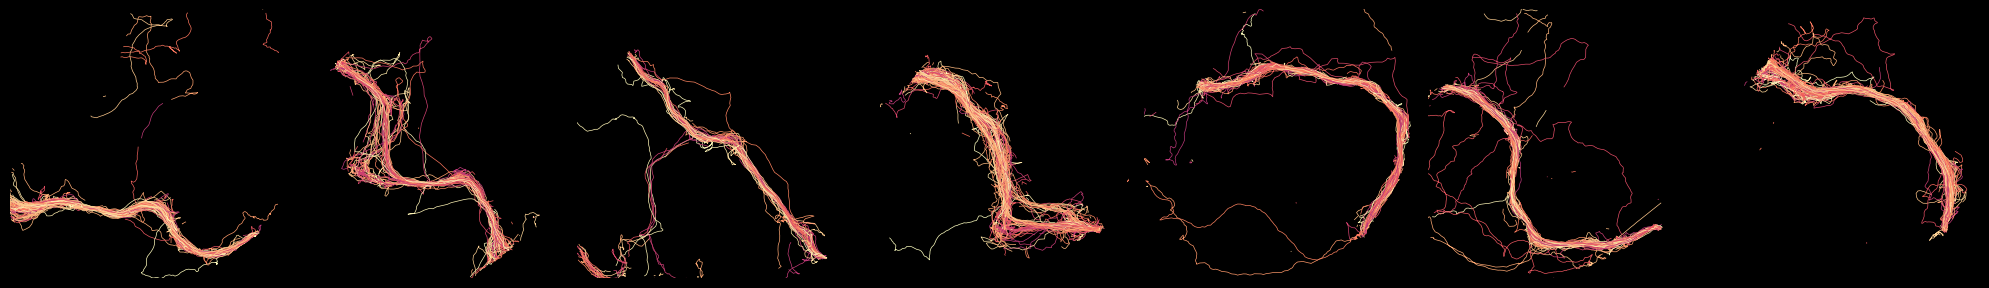

In [79]:
# for each video, plot the tracks
fig, axes = plt.subplots(1, len(database), figsize=(20, 5))
for i, data_file in enumerate(database.keys()):
    ax = axes[i]
    for track in database[data_file]['tracks']:
        ax.plot(track['centroid.y'], track['centroid.x'], '-', alpha=1, lw=0.5, color=plt.cm.magma(np.random.uniform(0.5, 1)))
    ax.set_xlim(0, DIMENSION[0])
    ax.set_ylim(0, DIMENSION[1])
    ax.axis('off')
    ax.set_aspect('equal')
# make 0,0 the top left corner
for ax in axes:
    ax.invert_yaxis()
plt.tight_layout()
plt.show()


In [9]:
# make a sample video of the tracks
video_name = 'sample_tracks.mp4'

# choose a video
data_file = list(database.keys())[0]
data = database[data_file]

video_file = os.path.join(raw_video_folder, data_file.split('.')[2][4:] + '.mp4')
tracks = data['tracks']

# create complete tracks by concatenating all tracks and reordering them by frame index
complete_tracks = pd.concat(tracks, ignore_index=True)
complete_tracks = complete_tracks.sort_values('frame_idx').reset_index(drop=True)

unique_tracks = complete_tracks.segment.unique()
# assign a unique random color to each track
colors = {track: np.random.uniform(0, 1, 3) for track in unique_tracks}

# get the video
cap = cv2.VideoCapture(video_file)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# get the video dimensions
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
out = cv2.VideoWriter(video_name, fourcc, fps, (width, height))


# for each frame, plot the tracks
for frame_idx in tqdm(range(len(complete_tracks)//20)):
    # move the video to the frame index
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    # get the frame
    ret, frame = cap.read()
    if not ret:
        break
    frame_tracks = complete_tracks[complete_tracks['frame_idx'] == frame_idx]
    track_ids = frame_tracks['segment'].values
    # plot the tip of the heads
    for i, track_id in enumerate(track_ids):
        # skip if any of the pose markers are nan
        if any([np.isnan(frame_tracks[marker + '.x'].values[i]) for marker in pose_markers]):
            continue
        color = (int(255*colors[track_id][0]), int(255*colors[track_id][1]), int(255*colors[track_id][2]))
        tip_of_head = frame_tracks[['tip_of_head.y', 'tip_of_head.x']].values[i]
        # plot the tip of the head as a hollow circle
        cv2.circle(frame, (int(tip_of_head[0]), int(tip_of_head[1])), 10, color, 2)
        # plot the antennas
        antennaL = frame_tracks[['antennaL.y', 'antennaL.x']].values[i]
        antennaR = frame_tracks[['antennaR.y', 'antennaR.x']].values[i]
        cv2.line(frame, (int(tip_of_head[0]), int(tip_of_head[1])), (int(antennaL[0]), int(antennaL[1])), color=color, thickness=2)
        cv2.line(frame, (int(tip_of_head[0]), int(tip_of_head[1])), (int(antennaR[0]), int(antennaR[1])), color=color, thickness=2)
        cv2.circle(frame, (int(antennaL[0]), int(antennaL[1])), 10, color, 2)
        cv2.circle(frame, (int(antennaR[0]), int(antennaR[1])), 10, color, 2)
        # plot the body axis
        petiole = frame_tracks[['petiole.y', 'petiole.x']].values[i]
        cv2.line(frame, (int(petiole[0]), int(petiole[1])), (int(tip_of_head[0]), int(tip_of_head[1])), color=color, thickness=2)
        cv2.circle(frame, (int(petiole[0]), int(petiole[1])), 10, color, 2)
        # plot the ovipositor
        ovipositor = frame_tracks[['ovipositor.y', 'ovipositor.x']].values[i]
        cv2.line(frame, (int(petiole[0]), int(petiole[1])), (int(ovipositor[0]), int(ovipositor[1])), color=color, thickness=2)
        cv2.circle(frame, (int(ovipositor[0]), int(ovipositor[1])), 10, color, 2)

    # write the frame
    out.write(frame)

# release the video
cap.release()
out.release()




  0%|          | 0/471 [00:00<?, ?it/s]

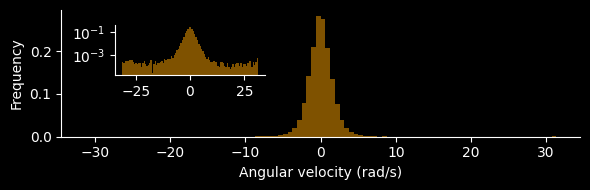

In [80]:
# get all angular velocities to calculate the distribution
angular_velocities = []
for data_file in database.keys():
    for track in database[data_file]['tracks']:
        angular_velocities.extend(track['angular_velocity'].values)
angular_velocities = np.array(angular_velocities)
angular_velocities = angular_velocities[~np.isnan(angular_velocities)]
# plot the distribution of angular velocities
fig, ax = plt.subplots(figsize=(6, 2))
# plot the histogram
ax.hist(angular_velocities, bins=100, density=True, color='orange', alpha=0.5)
ax.set_xlabel('Angular velocity (rad/s)')
ax.set_ylabel('Frequency')
# turn off top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# inset a log scale version of the plot
ax_inset = fig.add_axes([0.2, 0.6, 0.25, 0.25])
# plot the histogram
ax_inset.hist(angular_velocities, bins=100, density=True, color='orange', alpha=0.5)
ax_inset.set_yscale('log')
# turn off top and right spines
ax_inset.spines['top'].set_visible(False)
ax_inset.spines['right'].set_visible(False)
plt.tight_layout()

plt.show()
# get min and max angular velocities
min_angular_velocity = angular_velocities.min()
max_angular_velocity = angular_velocities.max()


In [26]:
def calculate_average_future_turn_direction(track, window_size=0.5):
    '''
    Calculate the average future turn direction of the track
    '''
    # make a copy of the track
    track = track.copy().reset_index(drop=True)
    # calculate the average future turn direction
    average_future_turn_direction = np.zeros(len(track))
    # turn window size into frames from seconds
    window_size = int(window_size * FRAME_RATE)
    for i in range(len(track)):
        future_turn_direction = track['turn_direction'].iloc[i:i+window_size].mean()
        average_future_turn_direction[i] = future_turn_direction
    # add to the track
    track.loc[:, 'average_future_turn_direction'] = average_future_turn_direction
    return track

# for each video, classify the angular motion and calculate the average future turn direction for each track
for data_file in database.keys():
    update_tracks = []
    for track in database[data_file]['tracks']:
        track = calculate_average_future_turn_direction(track)
        update_tracks.append(track)
    database[data_file]['tracks'] = update_tracks


In [27]:
# save the data to a pickle
with open('../data/vikram_raiding_data/sleap_prediction_round2-lowq/cleaned_database.pkl', 'wb') as f:
    pickle.dump(database, f)

## Odor Experience

In [28]:
# load the data from the pickle
with open('../data/vikram_raiding_data/sleap_prediction_round2-lowq/cleaned_database.pkl', 'rb') as f:
    database = pickle.load(f)

In [37]:
def estimate_trail_and_odor_experience(
    tracks,
    trail_props,
    antennal_pose_markers,
    body_pose_markers,
    dont_use_flags=True,
    max_frame=None,
):
    """
    Compute the trail map (aka odor distribution) for each frame, store the trail/odor
    values for relevant pose markers, and return both the updated tracks and a
    per-frame trail sequence.

    Parameters
    ----------
    tracks : list of pd.DataFrame
        List of dataframes containing all your tracked data. Each dataframe corresponds
        to one segment (e.g., one track over time). Must contain columns for:
          - 'frame_idx' (frame number)
          - 'segment' (an identifier grouping rows by track)
          - [pose].x and [pose].y for each marker of interest
          - 'pose_flag' (optional; used if dont_use_flags=True)
          - 'single_frame' (optional; used if remove_single_frame_tracks=True)
          - 'average_future_turn_direction' (optional; if you plan on using it later)
    trail_props : dict
        Dictionary containing the trail parameters, e.g.:
          - 'source': (str) the name of the body marker that emits the trail (e.g. 'ovipositor')
          - 'spread': (float) factor determining Gaussian spread
          - 'decay': (float) decay rate per second
    antennal_pose_markers : list of str
        Names of your antennal markers, e.g. ['antennaL', 'antennaR']
    body_pose_markers : list of str
        Names of the two body markers used to estimate body length, e.g. ['ovipositor', 'tip_of_head']
    dont_use_flags : bool, optional
        If True, flagged frames (where pose_flag != 0) will be removed before processing.
    max_frame : int, optional
        The maximum frame number in your dataset. If not provided, it will be inferred

    Returns
    -------
    updated_tracks : list of pd.DataFrame
        The same tracks as input, but with two extra columns (for each antennal marker):
          [marker].trail and [marker].trail_normalized,
        which indicate the odor/trail value at the marker's location.
    trail_sequence : np.ndarray
        3D array of shape (max_frame, height, width) containing the per-frame trail map
        as grayscale 8-bit images.
    """
    # 1) Combine your tracked data into a single DataFrame so it's easier to handle
    cleaned_data = tracks.copy()

    # If specified, remove flagged frames first
    if dont_use_flags:
        # Keep only rows where pose_flag == 0
        cleaned_data = [
            track[track['pose_flag'] == 0].reset_index(drop=True)
            for track in cleaned_data
        ]

    # Now concatenate all these smaller dataframes
    cleaned_data = pd.concat(cleaned_data).sort_values(
        ['frame_idx', 'segment']
    ).reset_index(drop=True)

    # 2) Compute the average body length for scaling the trail (Gaussian)
    # body_pose_markers: e.g. ['ovipositor', 'tip_of_head']
    x_diff = cleaned_data[body_pose_markers[0] + '.x'] - cleaned_data[body_pose_markers[1] + '.x']
    y_diff = cleaned_data[body_pose_markers[0] + '.y'] - cleaned_data[body_pose_markers[1] + '.y']
    body_length = np.nanmean(np.sqrt(x_diff**2 + y_diff**2))

    # The standard deviation for the Gaussian we add
    sd = trail_props['spread'] * body_length

    # 3) Prepare for trail map computation
    max_frame = int(cleaned_data['frame_idx'].max()) if max_frame is None else np.min([max_frame, int(cleaned_data['frame_idx'].max())])
    trail_map = np.zeros(DIMENSION, dtype=np.float32)

    # We'll store a version of the trail map for every frame (as 8-bit images)
    trail_sequence = np.zeros((max_frame + 1, DIMENSION[1], DIMENSION[0]), dtype=np.uint8)

    # Pre-calculate the decay factor per frame (since decay is per second)
    # If 'decay' is set to 1, there's effectively no decay.
    decay_factor = trail_props['decay'] ** (1 / FRAME_RATE)

    # 4) Main loop: For each frame, update the trail map and store trail values
    for frame in tqdm(range(max_frame + 1), desc="Computing trail map"):
        # Decay the trail map for this frame
        trail_map *= decay_factor

        # Get all the rows corresponding to the current frame
        current_indices = cleaned_data.index[cleaned_data['frame_idx'] == frame]
        current_tracks = cleaned_data.loc[current_indices]

        # The "source" is the body marker where the odor/trail originates
        # e.g. 'ovipositor.x' and 'ovipositor.y'
        source_x = current_tracks[trail_props['source'] + '.x'].values
        source_y = current_tracks[trail_props['source'] + '.y'].values

        # For each source (ant) at this frame, add a 2D Gaussian to the trail map
        for x, y in zip(source_x, source_y):
            # If x or y is NaN, skip
            if np.isnan(x) or np.isnan(y):
                continue
            # norm.pdf for each dimension
            gauss_x = norm.pdf(np.arange(DIMENSION[0]), x, sd)
            gauss_y = norm.pdf(np.arange(DIMENSION[1]), y, sd)
            addition = gauss_x[:, None] * gauss_y[None, :]
            # Normalize so that the peak is 1.0
            if addition.max() > 0:
                addition /= addition.max()
            trail_map += addition

        # 4a) Interpolate the odor value at antennal positions and store in DataFrame
        # We'll create a 2D interpolator from the current trail_map
        #   x-axis: 0..DIMENSION[0]-1
        #   y-axis: 0..DIMENSION[1]-1
        f = interp2d(np.arange(DIMENSION[0]), np.arange(DIMENSION[1]), trail_map.T, kind='linear')

        # For each ant in this frame, compute the trail at each antenna
        for idx in current_indices:
            for marker in antennal_pose_markers:
                # e.g. 'antennaL.x' and 'antennaL.y'
                ax = cleaned_data.at[idx, marker + '.x']
                ay = cleaned_data.at[idx, marker + '.y']
                if np.isnan(ax) or np.isnan(ay):
                    continue

                # Clip the positions so they're within the bounds
                ax_clipped = int(np.clip(ax, 0, DIMENSION[0] - 1))
                ay_clipped = int(np.clip(ay, 0, DIMENSION[1] - 1))

                # Interpolate the float value from trail_map
                # Note: f is defined with x as the first argument, y as second,
                # but we transposed the data above, so the usage is f(ax, ay).
                # Alternatively, we can just index directly from trail_map.
                odor_value = float(trail_map[ax_clipped, ay_clipped])

                cleaned_data.at[idx, marker + '.trail'] = odor_value

            # 4b) Normalize the odor value ( trail_normalized ) for convenience
            # We'll do it marker by marker. This normalizes *relative to the entire
            # trail map* in the current frame. If the entire map is zero, skip.
            map_min = trail_map.min()
            map_max = trail_map.max()
            if map_max > map_min:
                for marker in antennal_pose_markers:
                    val = cleaned_data.at[idx, marker + '.trail']
                    if pd.isna(val):
                        continue
                    norm_val = (val - map_min) / (map_max - map_min)
                    cleaned_data.at[idx, marker + '.trail_normalized'] = norm_val
            else:
                # If everything is zero, they are effectively normalized to 0
                for marker in antennal_pose_markers:
                    cleaned_data.at[idx, marker + '.trail_normalized'] = 0.0

        # 4c) Save the trail map for this frame in trail_sequence (8-bit image)
        # Scale to 0..255
        tmin, tmax = trail_map.min(), trail_map.max()
        if tmax > tmin:
            frame_scaled = (trail_map - tmin) / (tmax - tmin) * 255
        else:
            frame_scaled = trail_map * 0  # all zero if there's no range
        # Flip axes to match (height, width) in indexing
        frame_scaled = frame_scaled.astype(np.uint8).T
        trail_sequence[frame] = frame_scaled

    # 5) Convert the "cleaned_data" DataFrame back to a list of DataFrames by segment
    updated_tracks = []
    for segment_id in cleaned_data['segment'].unique():
        sub_df = cleaned_data[cleaned_data['segment'] == segment_id].copy()
        updated_tracks.append(sub_df)

    # Return the updated tracks (with .trail + .trail_normalized) and the trail sequence
    return updated_tracks, trail_sequence


def generate_video(
    tracks,
    video_file,
    output_path,
    trail_sequence,
    antennal_pose_markers,
    body_pose_markers,
    plot_values=False,
    max_frame=None,
):
    """
    Generate an output video that overlays the trail map on top of the input video
    (or uses the trail map alone if desired), and draws the ants with all pose markers.
    Arrows indicate differences in odor detection and future turn directions.

    Parameters
    ----------
    tracks : list of pd.DataFrame
        List of DataFrames containing the updated tracking data (including columns like
        '[marker].trail' and '[marker].trail_normalized').
    video_file : str
        Path to the original video file on disk (e.g., .mp4) that you want to use as background.
        If you prefer not to overlay on original frames, you can skip reading from the file or
        supply a dummy video.
    output_path : str
        Where to save the generated .mp4 (or other format) output.
    trail_sequence : np.ndarray
        3D array of shape (num_frames, height, width) containing the per-frame trail map
        (scaled to 0..255).
    antennal_pose_markers : list of str
        Antennal markers (e.g. ['antennaL', 'antennaR']).
    body_pose_markers : list of str
        Body markers used for drawing lines (e.g. ['petiole', 'tip_of_head', 'ovipositor']).
    plot_values : bool, optional
        If True, will plot the trail values on the video frames. This can be useful for debugging.
    max_frame : int, optional
        Maximum number of frames to process. If None, will process all frames.
    """
    # 1) Prepare the cleaned data
    # Combine the track list back into a single DataFrame for iteration
    cleaned_data = pd.concat(tracks).sort_values('frame_idx').reset_index(drop=True)
    max_frame = trail_sequence.shape[0] if max_frame is None else np.min([max_frame, trail_sequence.shape[0]])

    # Open the input video (if you want a background)
    cap = cv2.VideoCapture(video_file)
    # Basic checks on video
    if not cap.isOpened():
        print(f"Warning: could not open video file: {video_file}")
    
    # We'll define the frame rate and dimension from the global constants
    # but you can extract from `cap` if you want to match the original.
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(
        output_path,
        fourcc,
        FRAME_RATE,
        (DIMENSION[0], DIMENSION[1]),
        isColor=True  # We will produce a color video (since we overlay trail in grayscale).
    )

    # 2) Loop over frames, overlay the trail map, and draw ants
    for frame_idx in tqdm(range(max_frame), desc="Generating video"):
        # Attempt to read the corresponding frame from the video (background)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, back = cap.read()
        if not ret:
            # If reading fails, just create a blank background
            back = np.zeros((DIMENSION[1], DIMENSION[0], 3), dtype=np.uint8)

        # Convert the background to grayscale
        back_gray = cv2.cvtColor(back, cv2.COLOR_BGR2GRAY)

        # Pull out the corresponding trail map (already 8-bit grayscale).
        # shape = (height, width)
        trail_map_8bit = trail_sequence[frame_idx, :, :].T

        # Blend the background with the trail map for a nice overlay
        # We expand dims so that trail_map_8bit is (H, W, 1), then replicate to 3 channels
        trail_map_3ch = cv2.merge([trail_map_8bit, trail_map_8bit, trail_map_8bit])
        overlay = cv2.addWeighted(back_gray, 0.5, trail_map_8bit, 0.5, 0)

        # We'll keep the final frame in color for drawing. So replicate overlay to 3 channels.
        frame_to_write = cv2.cvtColor(overlay, cv2.COLOR_GRAY2BGR)

        # 2a) Draw the ants at this frame
        indices = cleaned_data.index[cleaned_data['frame_idx'] == frame_idx]
        for idx in indices:
            # We'll attempt to get the XY coords of relevant markers
            # In your original code, you used (int(y), int(x)) for circle centers,
            # so let's keep that consistent:
            def get_xy(marker_name):
                x_ = cleaned_data.at[idx, marker_name + '.x']
                y_ = cleaned_data.at[idx, marker_name + '.y']
                if np.isnan(x_) or np.isnan(y_):
                    raise ValueError("Marker is NaN.")
                return (int(y_), int(x_))

            # Prepare placeholders
            petiole = None
            tip_of_head = None
            ovipositor = None
            antennaL = None
            antennaR = None

            # 2a-i) Draw circles on each body marker
            try:
                petiole = get_xy('petiole')
                cv2.circle(frame_to_write, petiole, 5, (255, 255, 255), -1)
            except:
                pass
            try:
                tip_of_head = get_xy('tip_of_head')
                cv2.circle(frame_to_write, tip_of_head, 5, (255, 255, 255), -1)
            except:
                pass
            try:
                ovipositor = get_xy('ovipositor')
                cv2.circle(frame_to_write, ovipositor, 5, (255, 255, 255), -1)
            except:
                pass

            # For antenna markers, we may want to scale the circle size by the
            # normalized odor value
            map_min = 0.0
            map_max = 1.0
            # We'll rely on the .trail_normalized column from the first function
            try:
                antennaL = get_xy('antennaL')
                val_L = cleaned_data.at[idx, 'antennaL.trail_normalized']
                if pd.isna(val_L):
                    val_L = 0.0
                size_L = int(val_L * 30)  # scale up to ~30 px
                cv2.circle(frame_to_write, antennaL, size_L, (255, 255, 255), -1)
            except:
                pass

            try:
                antennaR = get_xy('antennaR')
                val_R = cleaned_data.at[idx, 'antennaR.trail_normalized']
                if pd.isna(val_R):
                    val_R = 0.0
                size_R = int(val_R * 30)
                cv2.circle(frame_to_write, antennaR, size_R, (255, 255, 255), -1)
            except:
                pass

            # 2a-ii) Draw lines connecting key markers
            def safe_line(pt1, pt2, color=(255, 255, 255), thickness=1):
                if pt1 is not None and pt2 is not None:
                    cv2.line(frame_to_write, pt1, pt2, color, thickness)

            safe_line(petiole, tip_of_head)
            safe_line(petiole, ovipositor)
            safe_line(tip_of_head, antennaL)
            safe_line(tip_of_head, antennaR)

            # 2a-iii) Draw an arrow from the higher antenna to the lower to indicate difference
            try:
                # We'll compute the difference in normalized odor
                # If difference is large enough, we show an arrow
                trail_L = cleaned_data.at[idx, 'antennaL.trail_normalized']
                trail_R = cleaned_data.at[idx, 'antennaR.trail_normalized']
                if pd.isna(trail_L) or pd.isna(trail_R):
                    raise ValueError("One or both antenna trails are NaN.")

                # We'll re-derive the petiole/tip of head for body-axis direction
                petiole_xy = get_xy('petiole')
                tip_of_head_xy = get_xy('tip_of_head')
                body_axis = np.array([tip_of_head_xy[0] - petiole_xy[0],
                                      tip_of_head_xy[1] - petiole_xy[1]], dtype=float)
                norm_body_axis = body_axis / (np.linalg.norm(body_axis) + 1e-9)

                # Shift the original antenna coordinates to draw an arrow offset
                offset = 30
                # We do the shift along the body axis so the arrow is in front
                # of the ant.
                def shift_point(pt, shift_val):
                    return (
                        pt[0] + int(norm_body_axis[0] * shift_val),
                        pt[1] + int(norm_body_axis[1] * shift_val),
                    )

                aL_shifted = shift_point(antennaL, offset)
                aR_shifted = shift_point(antennaR, offset)

                # We'll only draw an arrow if difference is not negligible
                diff = trail_L - trail_R
                if abs(diff) > 1e-3:
                    if diff < 0:
                        # R is bigger, arrow from L -> R
                        cv2.arrowedLine(frame_to_write, aL_shifted, aR_shifted, (255, 255, 255), 2, tipLength=0.5)
                        
                        if plot_values:
                            # We can add text if you'd like (e.g. how big the difference is)
                            text_str = f"{diff:.2f}"
                            cv2.putText(
                                frame_to_write,
                                text_str,
                                aL_shifted,
                                cv2.FONT_HERSHEY_SIMPLEX,
                                0.7,
                                (255, 255, 255),
                                2,
                                cv2.LINE_AA
                            )
                    else:
                        # L is bigger, arrow from R -> L
                        cv2.arrowedLine(frame_to_write, aR_shifted, aL_shifted, (255, 255, 255), 2, tipLength=0.5)
                        
                        if plot_values:
                            text_str = f"{diff:.2f}"
                            cv2.putText(
                                frame_to_write,
                                text_str,
                                aL_shifted,
                                cv2.FONT_HERSHEY_SIMPLEX,
                                0.7,
                                (255, 255, 255),
                                2,
                                cv2.LINE_AA
                            )

                # 2a-iv) Also draw the arrow for average future turn direction
                # We'll shift the points even further along the body axis
                aL_shifted2 = shift_point(aL_shifted, offset)
                aR_shifted2 = shift_point(aR_shifted, offset)

                # If the user has 'average_future_turn_direction' column
                # and it's not zero, we draw an arrow to indicate direction
                turn_dir = cleaned_data.at[idx, 'average_future_turn_direction'] \
                           if 'average_future_turn_direction' in cleaned_data.columns else 0
                if not pd.isna(turn_dir) and abs(turn_dir) > 1e-9:
                    if turn_dir > 0:
                        # positive turn => arrow from R->L or L->R, depending on your sign convention
                        cv2.arrowedLine(frame_to_write, aR_shifted2, aL_shifted2, (0, 0, 0), 2, tipLength=0.5)
                        if plot_values:
                            cv2.putText(
                                frame_to_write,
                                f"{turn_dir:.2f}",
                                aR_shifted2,
                                cv2.FONT_HERSHEY_SIMPLEX,
                                0.7,
                                (0, 0, 0),
                                2,
                                cv2.LINE_AA
                            )
                    else:
                        cv2.arrowedLine(frame_to_write, aL_shifted2, aR_shifted2, (0, 0, 0), 2, tipLength=0.5)
                        if plot_values:
                            cv2.putText(
                                frame_to_write,
                                f"{turn_dir:.2f}",
                                aL_shifted2,
                                cv2.FONT_HERSHEY_SIMPLEX,
                                0.7,
                                (0, 0, 0),
                                2,
                                cv2.LINE_AA
                            )
            except:
                # If any exception arises (NaNs, missing columns, etc.), skip silently.
                pass

        # 2b) Write out this final frame
        out.write(frame_to_write)

    # 3) Clean up video resources
    out.release()
    cap.release()

    print(f"Video saved to {output_path}")


In [38]:
# Example usage:
trail_props = {
    'source': 'ovipositor',
    'spread': 0.25,
    'decay': 1,
}
antennal_pose_markers = ['antennaL', 'antennaR']
body_pose_markers = ['ovipositor', 'tip_of_head']

# estimate the trail map for all videos and also save the trail map path
for data_file in list(database.keys()):
    video_file = os.path.join(raw_video_folder, data_file.split('.')[2][4:] + '.mp4')
    output_path = os.path.join(data_folder, data_file.replace('.csv', '_trail_map.mp4'))
    tracks = database[data_file]['tracks']
    tracks, trail_sequence = estimate_trail_and_odor_experience(tracks, trail_props, antennal_pose_markers, body_pose_markers)

    trail_props['tip_of_head.petiole.pose_distance_threshold'] = database[data_file]['tip_of_head.petiole.pose_distance_threshold']
    trail_props['petiole.ovipositor.pose_distance_threshold'] = database[data_file]['petiole.ovipositor.pose_distance_threshold']
    trail_props['tip_of_head.antennaL.pose_distance_threshold'] = database[data_file]['tip_of_head.antennaL.pose_distance_threshold']
    trail_props['tip_of_head.antennaR.pose_distance_threshold'] = database[data_file]['tip_of_head.antennaR.pose_distance_threshold']
    # generate the video
    generate_video(tracks, video_file, output_path, trail_sequence, antennal_pose_markers, body_pose_markers)
    database[data_file]['tracks'] = tracks
    database[data_file]['trail_sequence'] = trail_sequence
    database[data_file]['output_path'] = output_path
    print(f'{data_file}: Trail map generated')

Computing trail map:   0%|          | 0/6271 [00:00<?, ?it/s]

Generating video:   0%|          | 0/6271 [00:00<?, ?it/s]

Video saved to ../data/vikram_raiding_data/sleap_prediction_round2-lowq/labels.predicted_preclean.006_2018_05_25_19_58_cam_6_3.analysis_trail_map.mp4
labels.predicted_preclean.006_2018_05_25_19_58_cam_6_3.analysis.csv: Trail map generated


Computing trail map:   0%|          | 0/4197 [00:00<?, ?it/s]

Generating video:   0%|          | 0/4197 [00:00<?, ?it/s]

Video saved to ../data/vikram_raiding_data/sleap_prediction_round2-lowq/labels.predicted_preclean.004_2018_05_25_19_58_cam_5_2.analysis_trail_map.mp4
labels.predicted_preclean.004_2018_05_25_19_58_cam_5_2.analysis.csv: Trail map generated


Computing trail map:   0%|          | 0/4010 [00:00<?, ?it/s]

Generating video:   0%|          | 0/4010 [00:00<?, ?it/s]

Video saved to ../data/vikram_raiding_data/sleap_prediction_round2-lowq/labels.predicted_preclean.003_2018_05_25_19_58_cam_4_3.analysis_trail_map.mp4
labels.predicted_preclean.003_2018_05_25_19_58_cam_4_3.analysis.csv: Trail map generated


Computing trail map:   0%|          | 0/7926 [00:00<?, ?it/s]

Generating video:   0%|          | 0/7926 [00:00<?, ?it/s]

Video saved to ../data/vikram_raiding_data/sleap_prediction_round2-lowq/labels.predicted_preclean.002_2018_05_25_19_58_cam_4_2.analysis_trail_map.mp4
labels.predicted_preclean.002_2018_05_25_19_58_cam_4_2.analysis.csv: Trail map generated


Computing trail map:   0%|          | 0/4830 [00:00<?, ?it/s]

Generating video:   0%|          | 0/4830 [00:00<?, ?it/s]

Video saved to ../data/vikram_raiding_data/sleap_prediction_round2-lowq/labels.predicted_preclean.001_2018_05_25_19_58_cam_4_1.analysis_trail_map.mp4
labels.predicted_preclean.001_2018_05_25_19_58_cam_4_1.analysis.csv: Trail map generated


Computing trail map:   0%|          | 0/8424 [00:00<?, ?it/s]

Generating video:   0%|          | 0/8424 [00:00<?, ?it/s]

Video saved to ../data/vikram_raiding_data/sleap_prediction_round2-lowq/labels.predicted_preclean.005_2018_05_25_19_58_cam_6_1.analysis_trail_map.mp4
labels.predicted_preclean.005_2018_05_25_19_58_cam_6_1.analysis.csv: Trail map generated


Computing trail map:   0%|          | 0/22591 [00:00<?, ?it/s]

Generating video:   0%|          | 0/22591 [00:00<?, ?it/s]

Video saved to ../data/vikram_raiding_data/sleap_prediction_round2-lowq/labels.predicted_preclean.000_2018_05_22_09_53_cam_0_1.analysis_trail_map.mp4
labels.predicted_preclean.000_2018_05_22_09_53_cam_0_1.analysis.csv: Trail map generated


In [39]:
# save the data to a pickle
with open(f'../data/vikram_raiding_data/sleap_prediction_round2-lowq/cleaned_database_with_trail_{trail_props["spread"]}_{trail_props["decay"]}.pkl', 'wb') as f:
    pickle.dump(database, f)

## Analysis

In [84]:
# load the data 
with open('../data/vikram_raiding_data/sleap_prediction_round2-lowq/cleaned_database_with_trail_0.25_1.pkl', 'rb') as f:
    database = pickle.load(f)

In [85]:
# calculate across the whole dataset across different window sizes

# fit bernoulli distribution
def get_bernoulli_ci(correct):
    p = np.mean(correct)
    n = len(correct)
    se = np.sqrt(p * (1 - p) / n)
    ci = 1.96 * se
    return p, ci


future_window_sizes = [0.1, 0.3, 0.5, 0.7, 1.0]

means = np.zeros(len(future_window_sizes))
cis = np.zeros(len(future_window_sizes))
shuffle_means = np.zeros(len(future_window_sizes))
shuffle_cis = np.zeros(len(future_window_sizes))

for i, future_window_size in enumerate(future_window_sizes):
    print(f'Calculating for future window size: {future_window_size}')
    future_turn_directions = []
    antennal_differences = []
    for data_file in database.keys():
        for track in database[data_file]['tracks']:
            track = calculate_average_future_turn_direction(track, window_size=future_window_size)
            future_turn_directions.extend(np.sign(track['average_future_turn_direction']))
            antennal_difference = track['antennaL.trail_normalized'] - track['antennaR.trail_normalized']
            # ignore small differences
            antennal_difference[np.abs(antennal_difference) < 0.1] = np.nan
            antennal_differences.extend(np.sign(antennal_difference))
    future_turn_directions = np.array(future_turn_directions)
    antennal_differences = np.array(antennal_differences)

    # remove nans
    nans = np.isnan(future_turn_directions) | np.isnan(antennal_differences)
    future_turn_directions = future_turn_directions[~nans]
    antennal_differences = antennal_differences[~nans]

    # this is a binary sample, so we can calculate the bernoulli mean and confidence interval
    correct = future_turn_directions == antennal_differences
    p, ci = get_bernoulli_ci(correct)

    # get shuffle control
    n_shuffle = 100
    shuffle_p = []
    shuffle_ci = []
    for _ in range(n_shuffle):
        np.random.shuffle(future_turn_directions)
        correct = future_turn_directions == antennal_differences
        p_shuffle, ci_shuffle = get_bernoulli_ci(correct)
        shuffle_p.append(p_shuffle)
        shuffle_ci.append(ci_shuffle)

    shuffle_p = np.mean(shuffle_p)
    shuffle_ci = np.mean(shuffle_ci)

    means[i] = p
    cis[i] = ci
    shuffle_means[i] = shuffle_p
    shuffle_cis[i] = shuffle_ci

    print(f'Accuracy: {p:.2f} +/- {ci:.2f}')
    print(f'Control: {shuffle_p:.2f} +/- {shuffle_ci:.2f}')


Calculating for future window size: 0.1
Accuracy: 0.52 +/- 0.01
Control: 0.50 +/- 0.01
Calculating for future window size: 0.3
Accuracy: 0.62 +/- 0.01
Control: 0.49 +/- 0.01
Calculating for future window size: 0.5
Accuracy: 0.60 +/- 0.01
Control: 0.49 +/- 0.01
Calculating for future window size: 0.7
Accuracy: 0.57 +/- 0.01
Control: 0.49 +/- 0.01
Calculating for future window size: 1.0
Accuracy: 0.46 +/- 0.01
Control: 0.41 +/- 0.01


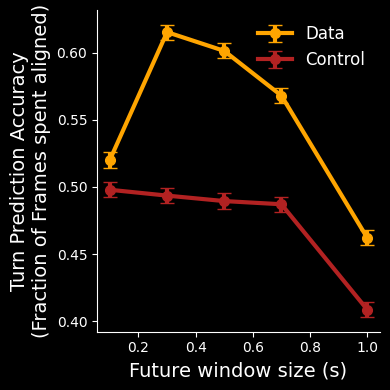

In [559]:
# plot the results
fig, ax = plt.subplots(figsize=(4, 4))

ax.errorbar(future_window_sizes, means, yerr=cis, fmt='-o', color='orange', label='Data', capsize=5, markersize=7, linewidth=3)
ax.errorbar(future_window_sizes, shuffle_means, yerr=shuffle_cis, fmt='-o', color='firebrick', label='Control', capsize=5, markersize=7, linewidth=3)
ax.set_xlabel('Future window size (s)', fontsize=14)
ax.set_ylabel('Turn Prediction Accuracy\n(Fraction of Frames spent aligned)', fontsize=14)

# turn off top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False, loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

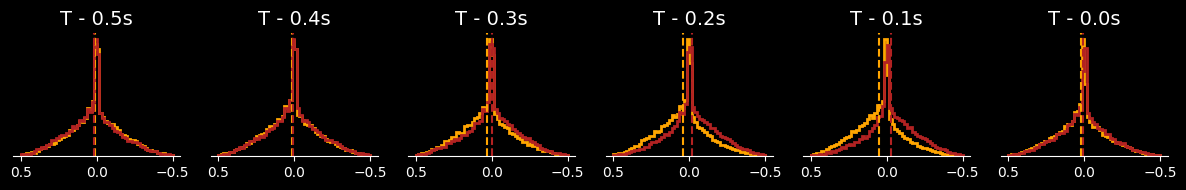

In [ ]:
look_backs = [0, 1, 2, 3, 4, 5]
fig, ax = plt.subplots(1, len(look_backs), figsize=(2*len(look_backs), 2))
bins = np.linspace(-0.5, 0.5, 61)

for i, look_back in enumerate(look_backs):
    diffs = []
    turn_directions = []
    for data_file in database.keys():
        for track in database[data_file]['tracks']:
            # get the turn directions
            td = track['turn_direction'].values[look_back:]
            # get the antennal differences
            if look_back == 0:
                ad = track['antennaL.trail_normalized'].values - track['antennaR.trail_normalized'].values
            else:
                ad = track['antennaL.trail_normalized'].values[:-look_back] - track['antennaR.trail_normalized'].values[:-look_back]
            
            # append to the list
            diffs.extend(ad)
            turn_directions.extend(td)
    # convert to numpy arrays
    diffs = np.array(diffs)
    turn_directions = np.array(turn_directions)

    # plot the results as a histogram

    ax[len(look_backs)-i-1].hist(diffs[turn_directions == 1], bins=bins, color='orange', alpha=1, label='Left Turn', density=True, histtype='step', linewidth=2)
    ax[len(look_backs)-i-1].hist(diffs[turn_directions == -1], bins=bins, color='firebrick', alpha=1, label='Right Turn', density=True, histtype='step', linewidth=2)
    # mark the means
    ax[len(look_backs)-i-1].axvline(np.nanmean(diffs[turn_directions == 1]), color='orange', linestyle='--')
    ax[len(look_backs)-i-1].axvline(np.nanmean(diffs[turn_directions == -1]), color='firebrick', linestyle='--')
    ax[len(look_backs)-i-1].set_title(f'T - {look_back/FRAME_RATE}s', fontsize=14)
    # turn off top and right spines
    ax[len(look_backs)-i-1].spines['top'].set_visible(False)
    ax[len(look_backs)-i-1].spines['right'].set_visible(False)
    ax[len(look_backs)-i-1].spines['left'].set_visible(False)
    # remove y ticks
    ax[len(look_backs)-i-1].set_yticks([])
    ax[len(look_backs)-i-1].invert_xaxis()

plt.tight_layout()
plt.show()

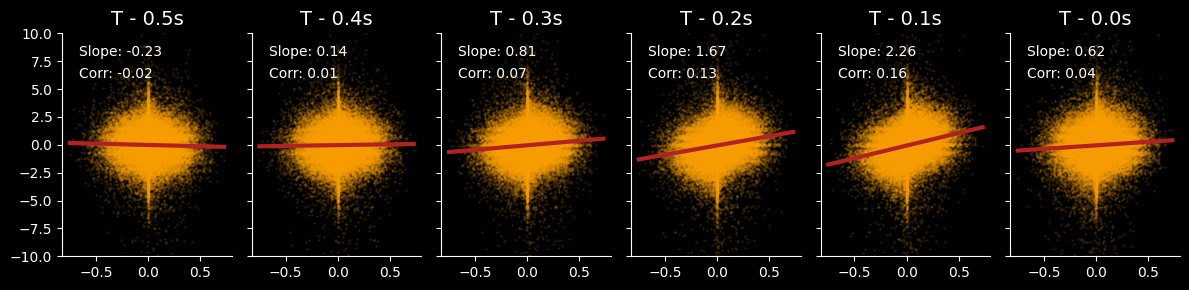

In [560]:
import statsmodels.api as sm

look_backs = [0, 1, 2, 3, 4, 5]
fig, ax = plt.subplots(1, len(look_backs), figsize=(2*len(look_backs), 3), sharey=True)

for i, look_back in enumerate(look_backs):
    diffs = []
    ang_velocities = []
    for data_file in database.keys():
        for track in database[data_file]['tracks']:
            # get the turn directions
            av = track['angular_velocity'].values[look_back:]
            # get the antennal differences
            if look_back == 0:
                ad = track['antennaL.trail_normalized'].values - track['antennaR.trail_normalized'].values
            else:
                ad = track['antennaL.trail_normalized'].values[:-look_back] - track['antennaR.trail_normalized'].values[:-look_back]
            
            # append to the list
            diffs.extend(ad)
            ang_velocities.extend(av)

    # convert to numpy arrays
    diffs = np.array(diffs)
    ang_velocities = np.array(ang_velocities)

    # plot the results as a scatter plot and fit a linear regression with a 95% confidence interval
    nans = np.isnan(diffs) | np.isnan(ang_velocities)
    x = diffs[~nans]
    y = ang_velocities[~nans]

    # sort the x values
    sort_idx = np.argsort(x)
    x = x[sort_idx]
    y = y[sort_idx]

    # fit the linear regression using statsmodels OLS method and get 95% confidence interval
    x_ = sm.add_constant(x)
    ols_model = sm.OLS(y, x_)
    est = ols_model.fit()
    out = est.conf_int(alpha=0.01, cols=None)

    slope = est.params[1]
    intercept = est.params[0]

    # calculate the correlation coefficient
    corr = np.corrcoef(x, y)[0, 1]


    # plot the results
    ax[len(look_backs)-i-1].scatter(x, y, color='orange', alpha=0.1, s=1)
    ax[len(look_backs)-i-1].plot(x, slope*x + intercept, color='firebrick', linestyle='-', linewidth=3)

    # write the slope and correlation coefficient along the regression line
    ax[len(look_backs)-i-1].text(0.1, 0.9, f'Slope: {slope:.2f}', transform=ax[len(look_backs)-i-1].transAxes, fontsize=10)
    ax[len(look_backs)-i-1].text(0.1, 0.8, f'Corr: {corr:.2f}', transform=ax[len(look_backs)-i-1].transAxes, fontsize=10)

    ax[len(look_backs)-i-1].set_title(f'T - {look_back/FRAME_RATE}s', fontsize=14)
    ax[len(look_backs)-i-1].set_ylim(-10, 10)

    # turn off top and right spines
    ax[len(look_backs)-i-1].spines['top'].set_visible(False)
    ax[len(look_backs)-i-1].spines['right'].set_visible(False)



plt.tight_layout()
plt.show()

In [525]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Suppose 'database' is a dict:
# database[data_file]['tracks'] is a list of DataFrames
# Each DataFrame has columns: ['velocity','angular_velocity','antennaL.trail_normalized','antennaR.trail_normalized']

past_window = 9   # how many past frames to use as predictors
future_window = 1 # how many future frames to predict

predictor_vars = ['velocity','|angular velocity|','turn direction','odor difference (L-R)','average odor intensity']
response_vars = ['velocity','|angular velocity|', 'turn direction']

all_predictors = []
all_responses = []
n_tracks = 0

for data_file in database.keys():
    for track in database[data_file]['tracks']:
        # Make sure track is sorted chronologically
        track = track.sort_values('frame_idx').reset_index(drop=True)

        # generate antennal difference and mean
        track['odor difference (L-R)'] = track['antennaL.trail_normalized'] - track['antennaR.trail_normalized']
        track['average odor intensity'] = (track['antennaL.trail_normalized'] + track['antennaR.trail_normalized']) / 2

        # generate angular velocity magnitude and direction
        track['|angular velocity|'] = np.abs(track['angular_velocity'])
        track['turn direction'] = np.sign(track['angular_velocity'])
        
        # Skip short tracks
        if len(track) < past_window + future_window:
            continue
        
        # Build flattened-lag rows
        for i in range(len(track) - past_window - future_window):
            # Past frames
            past_temp = track.iloc[i : i+past_window][predictor_vars].values
            past = past_temp.flatten()
            # Future frames
            future_temp = track.iloc[i+past_window : i+past_window+future_window][response_vars].values
            future = future_temp.flatten()
            
            all_predictors.append(past)
            all_responses.append(future)
        n_tracks += 1

# Convert to DataFrame / array
X = pd.DataFrame(all_predictors)
y = pd.DataFrame(all_responses, columns=[f"{v}_future" for v in response_vars])

# Remove rows with NaNs
missing_rows = X.isnull().any(axis=1) | y.isnull().any(axis=1)
X = X[~missing_rows]
y = y[~missing_rows]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Apply standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Shape of X: (42101, 45)
Shape of y: (42101, 3)


In [526]:
from sklearn.model_selection import KFold
from sklearn.metrics import check_scoring, r2_score, accuracy_score
from sklearn.utils import resample
from sklearn.inspection import permutation_importance


class SingleOutputAnalysis:
    """
    A pipeline for analyzing a single predicted variable using:
      1) Bootstrapped coefficient confidence intervals
      2) Cross-validation metric
      3) Permutation feature importance
      4) Dropout feature importance
    """
    def __init__(
        self,
        model,
        metric,  # A string or a callable compatible with sklearn's scoring
        feature_names=None,
        variable_groups=None,
        n_splits=5,
        n_bootstraps=1000,
        random_state=42,
        verbose=True,
    ):
        """
        Parameters
        ----------
        model : estimator
            The (single-output) estimator implementing .fit(X, y) and .predict(X).
            E.g. LinearRegression, Ridge, LogisticRegression, etc.
        metric : str or callable
            The metric for scoring the model. E.g. 'r2', 'accuracy', or a callable.
        feature_names : list of str, optional
            Names for each feature column in X. Used for interpretable importance results.
        variable_groups : dict, optional
            Mapping from variable name -> list of column indices in X
            for dropout feature importance. E.g.:
              {"velocity": [0,1,2], "angular_velocity": [3,4,5]}.
            If None, dropout importance is skipped.
        n_splits : int
            Number of splits for cross-validation.
        n_bootstraps : int
            Number of resamples for bootstrap confidence intervals.
        random_state : int
            Random seed for reproducibility.
        verbose : bool
            Whether to print progress during analysis.
        """
        self.model = model
        self.metric = metric
        self.feature_names = feature_names
        self.variable_groups = variable_groups
        self.n_splits = n_splits
        self.n_bootstraps = n_bootstraps
        self.random_state = random_state
        self.verbose = verbose

        # We'll create a scorer object to unify the metric interface
        # (This also works if metric is a recognized string like 'accuracy' or 'r2')
        self.scorer = check_scoring(model, scoring=metric)

    def fit_model(self, X, y):
        """
        Fit the model on the entire dataset for final use if desired.
        """
        self.model.fit(X, y)

    def bootstrap_coefs(self, X, y):
        """
        Compute bootstrap confidence intervals for the model's coefficients (if applicable).
        Returns mean, lower CI, and upper CI for each coefficient.
        """
        # We need to confirm the model has a coef_ attribute after fitting.
        # If using LogisticRegression or LinearRegression, this should be valid
        # for a single-output scenario.
        # If your model uses .coef_ differently, adjust accordingly.

        # Fit model once on the full data (to ensure .coef_ is present)
        self.model.fit(X, y)
        base_coef_shape = self.model.coef_.shape  # e.g. (n_features,) or (1, n_features)

        # If the shape is (1, n_features) for linear/logistic reg, flatten it.
        # We'll store them as 1D for simplicity (for single output).
        if len(base_coef_shape) == 2 and base_coef_shape[0] == 1:
            base_coef_shape = (base_coef_shape[1],)

        # Collect bootstrap coefficients
        all_coefs = []
        rng = np.random.default_rng(self.random_state)

        for i in tqdm(range(self.n_bootstraps), desc="Bootstrapping", disable=not self.verbose):
            # Resample
            indices = rng.integers(0, len(X), size=len(X))
            X_resampled = X[indices]
            y_resampled = y[indices]

            # Fit on resample
            self.model.fit(X_resampled, y_resampled)
            coef_ = self.model.coef_

            # Flatten if needed
            if coef_.ndim == 2 and coef_.shape[0] == 1:
                coef_ = coef_.ravel()

            all_coefs.append(coef_)

        all_coefs = np.array(all_coefs)  # shape: (n_bootstraps, n_features)

        mean_coefs = np.mean(all_coefs, axis=0)
        lower_ci = np.percentile(all_coefs, 2.5, axis=0)
        upper_ci = np.percentile(all_coefs, 97.5, axis=0)

        return mean_coefs, lower_ci, upper_ci

    def cross_val_score(self, X, y):
        """
        Perform cross-validation to get the mean metric.
        """
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        scores = []

        for train_idx, test_idx in tqdm(kf.split(X), total=self.n_splits, desc="Cross-validation", disable=not self.verbose):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            self.model.fit(X_train, y_train)
            y_pred = self.model.predict(X_test)
            fold_score = self.scorer._score_func(y_test, y_pred)
            scores.append(fold_score)

        return np.mean(scores), np.std(scores)

    def permutation_importance(self, X, y, n_repeats=10):
        """
        Perform cross-validated permutation importance for single-output model.
        Returns a DataFrame with mean importance and std dev across folds.
        """
        from copy import deepcopy

        if self.feature_names is None:
            fnames = [f"Feature_{i}" for i in range(X.shape[1])]
        else:
            fnames = self.feature_names

        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)

        importances_folds = []
        stddevs_folds = []

        rng = np.random.default_rng(self.random_state)

        for train_idx, test_idx in tqdm(kf.split(X), total=self.n_splits, desc="Permutation Importance", disable=not self.verbose):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Fit model
            model_clone = deepcopy(self.model)
            model_clone.fit(X_train, y_train)

            # Baseline score
            baseline_score = self.scorer._score_func(y_test, model_clone.predict(X_test))

            # Compute importance by permuting each column
            col_importances = []

            for col_i in range(X.shape[1]):
                X_test_permuted = X_test.copy()
                # Shuffle one feature's column
                perm_indices = rng.permutation(len(X_test_permuted))
                X_test_permuted[:, col_i] = X_test_permuted[perm_indices, col_i]

                perm_score = self.scorer._score_func(y_test, model_clone.predict(X_test_permuted))
                # relative drop
                drop = (baseline_score - perm_score)/baseline_score
                col_importances.append(drop)

            importances_folds.append(col_importances)

        importances_folds = np.array(importances_folds)  # (n_splits, n_features)
        mean_importances = importances_folds.mean(axis=0)
        std_importances = importances_folds.std(axis=0)

        df_perm = pd.DataFrame({
            "Feature": fnames,
            "Permutation Importance (mean drop)": mean_importances,
            "Permutation Importance (std dev)": std_importances
        }).sort_values(by="Permutation Importance (mean drop)", ascending=False)

        return df_perm

    def dropout_importance(self, X, y):
        """
        Perform dropout importance by shuffling the entire group of features together
        and measuring drop in performance. Cross-validated approach.
        """
        if self.variable_groups is None:
            print("No 'variable_groups' provided; skipping dropout importance.")
            return None

        from copy import deepcopy

        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        all_dropout_results = []

        rng = np.random.default_rng(self.random_state)

        for train_idx, test_idx in tqdm(kf.split(X), total=self.n_splits, desc="Dropout Importance", disable=not self.verbose):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Fit model
            model_clone = deepcopy(self.model)
            model_clone.fit(X_train, y_train)

            # Baseline score
            baseline_score = self.scorer._score_func(y_test, model_clone.predict(X_test))

            dropout_dict = {}
            for var, indices in self.variable_groups.items():
                X_test_permuted = X_test.copy()

                # Shuffle all columns in 'indices' together
                perm_indices = rng.permutation(len(X_test_permuted))
                X_test_permuted[:, indices] = X_test_permuted[perm_indices][:, indices]

                perm_score = self.scorer._score_func(y_test, model_clone.predict(X_test_permuted))
                drop = (baseline_score - perm_score)
                dropout_dict[var] = drop

            all_dropout_results.append(dropout_dict)

        df_all = pd.DataFrame(all_dropout_results)  # shape (n_splits, len(variable_groups))
        mean_importances = df_all.mean(axis=0)
        std_importances = df_all.std(axis=0)

        df_dropout = pd.DataFrame({
            "Variable": mean_importances.index,
            "Dropout Importance (mean drop)": mean_importances.values,
            "Dropout Importance (std dev)": std_importances.values
        }).sort_values(by="Dropout Importance (mean drop)", ascending=False)

        return df_dropout

    def run_analysis(self, X, y):
        """
        Executes:
          - Bootstrap for coefs
          - Cross-validation metric
          - Permutation importance
          - Dropout importance
        Returns a dict of results/dataframes.
        """
        results = {}

        if self.verbose:
            print("Running analysis...")

        # 1) Bootstrap intervals
        if self.verbose:
            print("Computing bootstrap confidence intervals for coefficients...")
        mean_coefs, lower_ci, upper_ci = None, None, None
        try:
            mean_coefs, lower_ci, upper_ci = self.bootstrap_coefs(X, y)
            results["bootstrap_coefs"] = (mean_coefs, lower_ci, upper_ci)
        except AttributeError:
            print("Model does not expose .coef_ (or single-output). Skipping bootstrap CIs.")


        # 2) Cross-validation
        if self.verbose:
            print("Computing cross-validated metric...")
        mean_score, std_score = self.cross_val_score(X, y)
        results["cv_score_mean"] = mean_score
        results["cv_score_std"] = std_score

        # 3) Permutation importance
        if self.verbose:
            print("Computing permutation importance...")
        df_perm = self.permutation_importance(X, y)
        results["df_permutation_importance"] = df_perm

        # 4) Dropout importance
        if self.variable_groups is not None:
            if self.verbose:
                print("Computing dropout importance...")
            df_dropout = self.dropout_importance(X, y)
            results["df_dropout_importance"] = df_dropout

        return results


In [527]:
from sklearn.base import RegressorMixin, BaseEstimator

# create a log link linear regression model with coefficients in the original scale
class LogLinkLinearRegression(RegressorMixin, BaseEstimator):
    def __init__(self):
        self.model = LinearRegression()
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        self.model.fit(X, np.log(y + 1e-9))
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        return self

    def predict(self, X):
        return np.exp(self.model.predict(X)) - 1e-9

In [547]:
# For example, let's do a logistic regression on a direction variable
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.ticker as mtick

Running analysis...
Computing bootstrap confidence intervals for coefficients...


Bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing cross-validated metric...


Cross-validation:   0%|          | 0/100 [00:00<?, ?it/s]

Computing permutation importance...


Permutation Importance:   0%|          | 0/100 [00:00<?, ?it/s]

Computing dropout importance...


Dropout Importance:   0%|          | 0/100 [00:00<?, ?it/s]

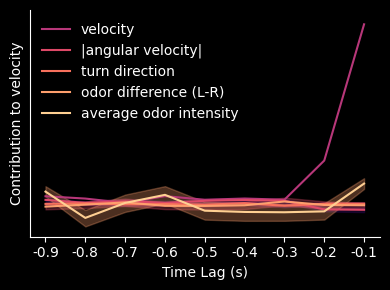

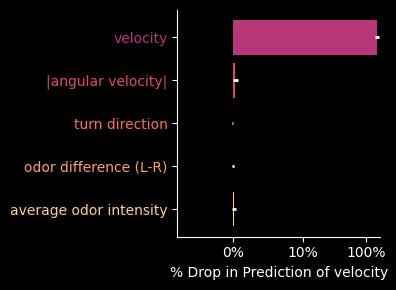

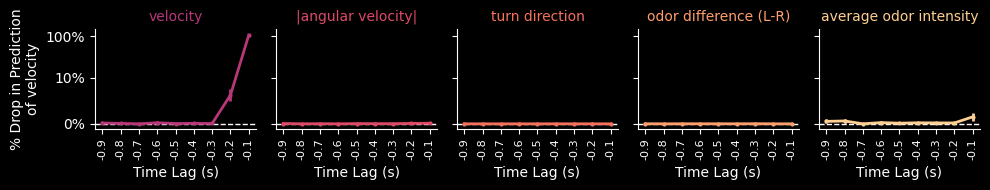

In [549]:
analysis = SingleOutputAnalysis(
    model=LinearRegression(),
    metric= 'r2',
    feature_names= [f"{v}_lag_{t}" for t in range(past_window) for v in predictor_vars],
    variable_groups= {
            var: [i for i, col_name in enumerate([f"{v}_lag_{t}" for t in range(past_window) for v in predictor_vars]) if col_name.startswith(var)]
            for var in predictor_vars
        },
    n_splits=100,
    n_bootstraps=1000,
    random_state=12345,
    verbose=True
)

# Get a single output variable
predicted_var = 'velocity_future'
y_small = y[predicted_var].values

results = analysis.run_analysis(X_scaled, y_small)

# plot the bootstrap confidence intervals
fig, ax = plt.subplots(figsize=(4, 3))
mean_coefs, lower_ci, upper_ci = results['bootstrap_coefs']
# reshape the coefficients
mean_coefs = mean_coefs.reshape((past_window, len(predictor_vars)))
lower_ci = lower_ci.reshape((past_window, len(predictor_vars)))
upper_ci = upper_ci.reshape((past_window, len(predictor_vars)))
# plot the results
for i, var in enumerate(predictor_vars):
    ax.plot(mean_coefs[:, i], label=var, color=plt.cm.magma(0.5 + 0.5*i/len(predictor_vars)))
    ax.fill_between(range(past_window), lower_ci[:, i], upper_ci[:, i], alpha=0.3, color=plt.cm.magma(i/len(predictor_vars)))
ax.set_xticks(range(past_window), [(i-past_window)/FRAME_RATE for i in range(past_window)])
ax.set_yticks([])
ax.set_xlabel('Time Lag (s)')
ax.set_ylabel(f'Contribution to {predicted_var.split("_")[0]}')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# plot the dropout importance
df_dropout = results['df_dropout_importance']
# order variables by predictor_vars
df_dropout['Variable'] = pd.Categorical(df_dropout['Variable'], predictor_vars)
df_dropout = df_dropout.sort_values('Variable')
# plot the results
fig, ax = plt.subplots(figsize=(4, 3))
ax.barh(df_dropout['Variable'], 
        df_dropout['Dropout Importance (mean drop)'], 
        xerr=df_dropout['Dropout Importance (std dev)'], 
        color=plt.cm.magma([0.5 + 0.5*i/len(predictor_vars) for i in range(len(predictor_vars))]),
        error_kw={'elinewidth': 2, 'ecolor': 'white'})
ax.set_xlabel('% Drop in Prediction of ' + predicted_var.split("_")[0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# change the color of the y labels
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color(plt.cm.magma(0.5 + 0.5*i/len(predictor_vars)))
ax.invert_yaxis()
ax.set_xscale('symlog', linthresh=0.1)
# write x ticks in percentage
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

# plot the permutation importance
df_perm = results['df_permutation_importance']
# sort by feature names
df_perm = df_perm.sort_values(by='Feature', ascending=True).reset_index(drop=True)
# rename the features
def rename_features(feature):
    feature,_,lag = feature.split('_')
    return f'{feature} {(int(lag)-past_window)/FRAME_RATE}'
df_perm['Feature'] = df_perm['Feature'].apply(rename_features)
# plot the results for each feature separately

fig, ax = plt.subplots(1,len(predictor_vars), figsize=(2*len(predictor_vars), 2), sharey=True)
# split the features into groups
for i, var in enumerate(predictor_vars):
    df = df_perm[df_perm['Feature'].str.startswith(var)]
    # remove the feature name
    df['Feature'] = df['Feature'].apply(lambda x: x.split(' ')[-1])
    ax[i].errorbar(df['Feature'], df['Permutation Importance (mean drop)'], yerr=df['Permutation Importance (std dev)'], fmt='o-', markersize=2, linewidth=2, color=plt.cm.magma(0.5 + 0.5*i/len(predictor_vars)))
    ax[i].axhline(0, color='white', linestyle='--', linewidth=1)
    ax[i].set_xticklabels(df['Feature'], rotation=90, fontsize=8)
    ax[i].set_xlabel('Time Lag (s)')
    if i == 0:
        ax[i].set_ylabel('% Drop in Prediction\nof ' + predicted_var.split("_")[0])
    # ax[i].set_ylim(np.min(df['Permutation Importance (mean drop)']*100) - 1, np.max(df['Permutation Importance (mean drop)']*100) + 10)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_title(var, color=plt.cm.magma(0.5 + 0.5*i/len(predictor_vars)), fontsize=10)
    ax[i].set_yscale('symlog', linthresh=0.1)
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()


Running analysis...
Computing bootstrap confidence intervals for coefficients...


Bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing cross-validated metric...


Cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

Computing permutation importance...


Permutation Importance:   0%|          | 0/10 [00:00<?, ?it/s]

Computing dropout importance...


Dropout Importance:   0%|          | 0/10 [00:00<?, ?it/s]

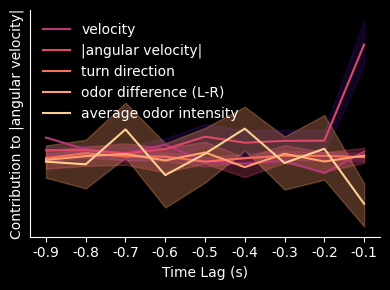

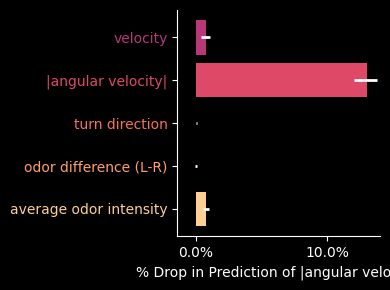

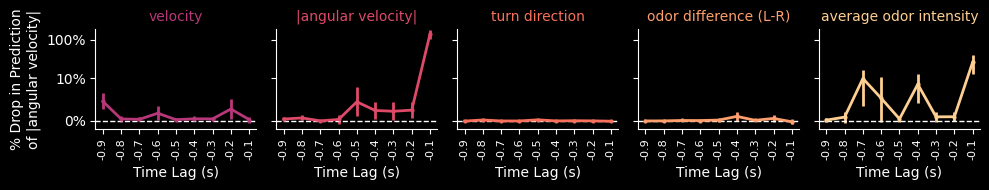

In [551]:
analysis = SingleOutputAnalysis(
    model=LinearRegression(),
    metric= 'r2',
    feature_names= [f"{v}_lag_{t}" for t in range(past_window) for v in predictor_vars],
    variable_groups= {
            var: [i for i, col_name in enumerate([f"{v}_lag_{t}" for t in range(past_window) for v in predictor_vars]) if col_name.startswith(var)]
            for var in predictor_vars
        },
    n_splits=10,
    n_bootstraps=1000,
    random_state=12345,
    verbose=True
)

# Get a single output variable
predicted_var = '|angular velocity|_future'
y_small = y[predicted_var].values

results = analysis.run_analysis(X_scaled, y_small)

# plot the bootstrap confidence intervals
fig, ax = plt.subplots(figsize=(4, 3))
mean_coefs, lower_ci, upper_ci = results['bootstrap_coefs']
# reshape the coefficients
mean_coefs = mean_coefs.reshape((past_window, len(predictor_vars)))
lower_ci = lower_ci.reshape((past_window, len(predictor_vars)))
upper_ci = upper_ci.reshape((past_window, len(predictor_vars)))
# plot the results
for i, var in enumerate(predictor_vars):
    ax.plot(mean_coefs[:, i], label=var, color=plt.cm.magma(0.5 + 0.5*i/len(predictor_vars)))
    ax.fill_between(range(past_window), lower_ci[:, i], upper_ci[:, i], alpha=0.3, color=plt.cm.magma(i/len(predictor_vars)))
ax.set_xticks(range(past_window), [(i-past_window)/FRAME_RATE for i in range(past_window)])
ax.set_yticks([])
ax.set_xlabel('Time Lag (s)')
ax.set_ylabel(f'Contribution to {predicted_var.split("_")[0]}')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# plot the dropout importance
df_dropout = results['df_dropout_importance']
# order variables by predictor_vars
df_dropout['Variable'] = pd.Categorical(df_dropout['Variable'], predictor_vars)
df_dropout = df_dropout.sort_values('Variable')
# plot the results
fig, ax = plt.subplots(figsize=(4, 3))
ax.barh(df_dropout['Variable'], 
        df_dropout['Dropout Importance (mean drop)'], 
        xerr=df_dropout['Dropout Importance (std dev)'], 
        color=plt.cm.magma([0.5 + 0.5*i/len(predictor_vars) for i in range(len(predictor_vars))]),
        error_kw={'elinewidth': 2, 'ecolor': 'white'})
ax.set_xlabel('% Drop in Prediction of ' + predicted_var.split("_")[0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# change the color of the y labels
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color(plt.cm.magma(0.5 + 0.5*i/len(predictor_vars)))
ax.invert_yaxis()
ax.set_xscale('symlog', linthresh=0.1)
# write x ticks in percentage
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

# plot the permutation importance
df_perm = results['df_permutation_importance']
# sort by feature names
df_perm = df_perm.sort_values(by='Feature', ascending=True).reset_index(drop=True)
# rename the features
def rename_features(feature):
    feature,_,lag = feature.split('_')
    return f'{feature} {(int(lag)-past_window)/FRAME_RATE}'
df_perm['Feature'] = df_perm['Feature'].apply(rename_features)
# plot the results for each feature separately

fig, ax = plt.subplots(1,len(predictor_vars), figsize=(2*len(predictor_vars), 2), sharey=True)
# split the features into groups
for i, var in enumerate(predictor_vars):
    df = df_perm[df_perm['Feature'].str.startswith(var)]
    # remove the feature name
    df['Feature'] = df['Feature'].apply(lambda x: x.split(' ')[-1])
    ax[i].errorbar(df['Feature'], df['Permutation Importance (mean drop)'], yerr=df['Permutation Importance (std dev)'], fmt='o-', markersize=2, linewidth=2, color=plt.cm.magma(0.5 + 0.5*i/len(predictor_vars)))
    ax[i].axhline(0, color='white', linestyle='--', linewidth=1)
    ax[i].set_xticklabels(df['Feature'], rotation=90, fontsize=8)
    ax[i].set_xlabel('Time Lag (s)')
    if i == 0:
        ax[i].set_ylabel('% Drop in Prediction\nof ' + predicted_var.split("_")[0])
    # ax[i].set_ylim(np.min(df['Permutation Importance (mean drop)']*100) - 1, np.max(df['Permutation Importance (mean drop)']*100) + 10)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_title(var, color=plt.cm.magma(0.5 + 0.5*i/len(predictor_vars)), fontsize=10)
    ax[i].set_yscale('symlog', linthresh=0.1)
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()


Running analysis...
Computing bootstrap confidence intervals for coefficients...


Bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing cross-validated metric...


Cross-validation:   0%|          | 0/100 [00:00<?, ?it/s]

Computing permutation importance...


Permutation Importance:   0%|          | 0/100 [00:00<?, ?it/s]

Computing dropout importance...


Dropout Importance:   0%|          | 0/100 [00:00<?, ?it/s]

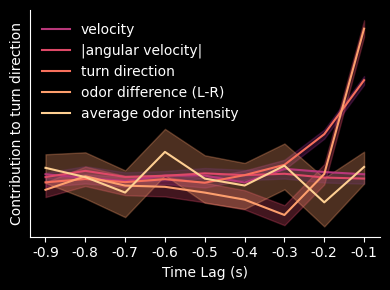

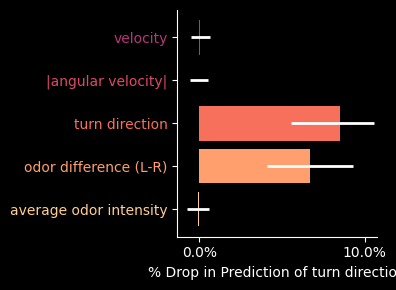

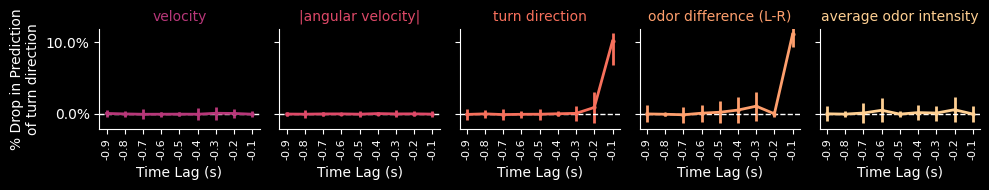

In [556]:
analysis = SingleOutputAnalysis(
    model=LogisticRegression(),
    metric= 'accuracy',
    feature_names= [f"{v}_lag_{t}" for t in range(past_window) for v in predictor_vars],
    variable_groups= {
            var: [i for i, col_name in enumerate([f"{v}_lag_{t}" for t in range(past_window) for v in predictor_vars]) if col_name.startswith(var)]
            for var in predictor_vars
        },
    n_splits=100,
    n_bootstraps=1000,
    random_state=12345,
    verbose=True
)

# Get a single output variable
predicted_var = 'turn direction_future'
y_small = y[predicted_var].values
# convert to binary
y_small = (y_small > 0).astype(int)

results = analysis.run_analysis(X_scaled, y_small)

# plot the bootstrap confidence intervals
fig, ax = plt.subplots(figsize=(4, 3))
mean_coefs, lower_ci, upper_ci = results['bootstrap_coefs']
# reshape the coefficients
mean_coefs = mean_coefs.reshape((past_window, len(predictor_vars)))
lower_ci = lower_ci.reshape((past_window, len(predictor_vars)))
upper_ci = upper_ci.reshape((past_window, len(predictor_vars)))
# plot the results
for i, var in enumerate(predictor_vars):
    ax.plot(mean_coefs[:, i], label=var, color=plt.cm.magma(0.5 + 0.5*i/len(predictor_vars)))
    ax.fill_between(range(past_window), lower_ci[:, i], upper_ci[:, i], alpha=0.3, color=plt.cm.magma(i/len(predictor_vars)))
ax.set_xticks(range(past_window), [(i-past_window)/FRAME_RATE for i in range(past_window)])
ax.set_yticks([])
ax.set_xlabel('Time Lag (s)')
ax.set_ylabel(f'Contribution to {predicted_var.split("_")[0]}')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# plot the dropout importance
df_dropout = results['df_dropout_importance']
# order variables by predictor_vars
df_dropout['Variable'] = pd.Categorical(df_dropout['Variable'], predictor_vars)
df_dropout = df_dropout.sort_values('Variable')
# plot the results
fig, ax = plt.subplots(figsize=(4, 3))
ax.barh(df_dropout['Variable'], 
        df_dropout['Dropout Importance (mean drop)'], 
        xerr=df_dropout['Dropout Importance (std dev)'], 
        color=plt.cm.magma([0.5 + 0.5*i/len(predictor_vars) for i in range(len(predictor_vars))]),
        error_kw={'elinewidth': 2, 'ecolor': 'white'})
ax.set_xlabel('% Drop in Prediction of ' + predicted_var.split("_")[0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# change the color of the y labels
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color(plt.cm.magma(0.5 + 0.5*i/len(predictor_vars)))
ax.invert_yaxis()
ax.set_xscale('symlog', linthresh=0.1)
# write x ticks in percentage
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

# plot the permutation importance
df_perm = results['df_permutation_importance']
# sort by feature names
df_perm = df_perm.sort_values(by='Feature', ascending=True).reset_index(drop=True)
# rename the features
def rename_features(feature):
    feature,_,lag = feature.split('_')
    return f'{feature} {(int(lag)-past_window)/FRAME_RATE}'
df_perm['Feature'] = df_perm['Feature'].apply(rename_features)
# plot the results for each feature separately

fig, ax = plt.subplots(1,len(predictor_vars), figsize=(2*len(predictor_vars), 2), sharey=True)
# split the features into groups
for i, var in enumerate(predictor_vars):
    df = df_perm[df_perm['Feature'].str.startswith(var)]
    # remove the feature name
    df['Feature'] = df['Feature'].apply(lambda x: x.split(' ')[-1])
    ax[i].errorbar(df['Feature'], df['Permutation Importance (mean drop)'], yerr=df['Permutation Importance (std dev)'], fmt='o-', markersize=2, linewidth=2, color=plt.cm.magma(0.5 + 0.5*i/len(predictor_vars)))
    ax[i].axhline(0, color='white', linestyle='--', linewidth=1)
    ax[i].set_xticklabels(df['Feature'], rotation=90, fontsize=8)
    ax[i].set_xlabel('Time Lag (s)')
    if i == 0:
        ax[i].set_ylabel('% Drop in Prediction\nof ' + predicted_var.split("_")[0])
    # ax[i].set_ylim(np.min(df['Permutation Importance (mean drop)']*100) - 1, np.max(df['Permutation Importance (mean drop)']*100) + 10)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_title(var, color=plt.cm.magma(0.5 + 0.5*i/len(predictor_vars)), fontsize=10)
    ax[i].set_yscale('symlog', linthresh=0.1)
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()


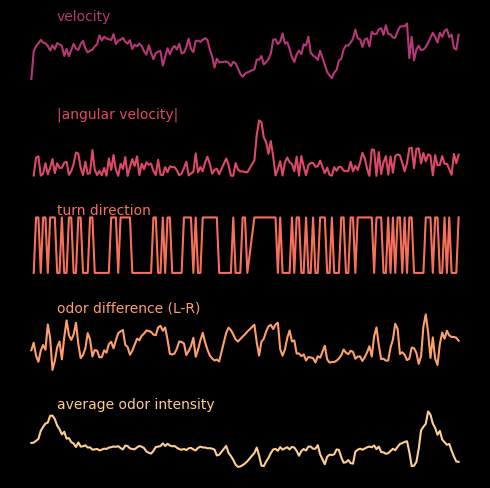

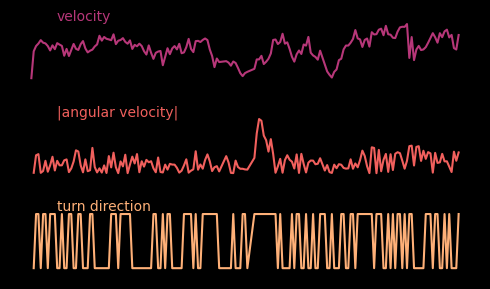

In [586]:
# get example data for plotting
data_file = list(database.keys())[0]
# find a long track
track_lengths = [len(track) for track in database[data_file]['tracks']]
track = database[data_file]['tracks'][np.argmax(track_lengths)]
track = track.sort_values('frame_idx').reset_index(drop=True)

# generate variables
track['odor difference (L-R)'] = track['antennaL.trail_normalized'] - track['antennaR.trail_normalized']
track['average odor intensity'] = (track['antennaL.trail_normalized'] + track['antennaR.trail_normalized']) / 2
track['|angular velocity|'] = np.abs(track['angular_velocity'])
track['turn direction'] = np.sign(track['angular_velocity'])

# plot the time series of the variables
fig, ax = plt.subplots(len(predictor_vars), 1, figsize=(5, 1*len(predictor_vars)), sharex=True)
for i, var in enumerate(predictor_vars):
    ax[i].plot(track['frame_idx']/FRAME_RATE, track[var], color=plt.cm.magma(0.5 + 0.5*i/len(predictor_vars)))
    ax[i].text(0.1, 0.9, var, transform=ax[i].transAxes, fontsize=10, color=plt.cm.magma(0.5 + 0.5*i/len(predictor_vars)))
    ax[i].set_ylim(np.min(track[var]) - 0.2*(np.max(track[var]) - np.min(track[var])), np.max(track[var]) + 0.2*(np.max(track[var]) - np.min(track[var])))
    ax[i].set_axis_off()
plt.tight_layout()
plt.show()

# make one for only the predicted variables
predicted_vars = ['velocity', '|angular velocity|', 'turn direction']
# plot the time series of the variables
fig, ax = plt.subplots(len(predicted_vars), 1, figsize=(5, 1*len(predicted_vars)), sharex=True)
for i, var in enumerate(predicted_vars):
    ax[i].plot(track['frame_idx']/FRAME_RATE, track[var], color=plt.cm.magma(0.5 + 0.5*i/len(predicted_vars)))
    ax[i].text(0.1, 0.9, var, transform=ax[i].transAxes, fontsize=10, color=plt.cm.magma(0.5 + 0.5*i/len(predicted_vars)))
    ax[i].set_ylim(np.min(track[var]) - 0.2*(np.max(track[var]) - np.min(track[var])), np.max(track[var]) + 0.2*(np.max(track[var]) - np.min(track[var])))
    ax[i].set_axis_off()
plt.tight_layout()
plt.show()


In [19]:
def estimate_trail_map(tracks, video_file, output_path, trail_props, antennal_pose_markers, body_pose_markers, dont_use_flags=True, remove_single_frame_tracks=False):
    '''
    Generates a trail map video from the cleaned data, using the provided trail properties and antennal pose markers.
    '''
    # generate the cleaned data
    cleaned_data = tracks.copy()
    # remove flagged frames
    if dont_use_flags:
        cleaned_data = [track[track['pose_flag'] == 0].reset_index(drop=True) for track in cleaned_data]
    # remove single frame tracks
    if remove_single_frame_tracks:
        cleaned_data = [track[track['single_frame'] == 0].reset_index(drop=True) for track in cleaned_data]

    cleaned_data = pd.concat(cleaned_data).sort_values(['frame_idx', 'segment']).reset_index(drop=True)


    # Get average body length
    x_diff = cleaned_data[body_pose_markers[0] + '.x'] - cleaned_data[body_pose_markers[1] + '.x']
    y_diff = cleaned_data[body_pose_markers[0] + '.y'] - cleaned_data[body_pose_markers[1] + '.y']
    body_length = np.nanmean(np.sqrt(x_diff**2 + y_diff**2))

    # Set the spread of the trail in pixels
    sd = trail_props['spread'] * body_length

    # Get the maximum frame index
    max_frame = int(cleaned_data['frame_idx'].max())

    # Create the empty trail map
    trail_map = np.zeros(DIMENSION)

    # Set up video reader
    cap = cv2.VideoCapture(video_file)

    # Set up video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, FRAME_RATE, (DIMENSION[0], DIMENSION[1]), isColor=False)

    # Loop over the frames
    for frame in tqdm(range(max_frame//20)):

        # move the video to the frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame)

        # Read the frame
        ret, back = cap.read()
        if not ret:
            print('Error reading frame')
            break
        # convert to grayscale
        back = cv2.cvtColor(back, cv2.COLOR_BGR2GRAY)

        # Decay the trail map
        trail_map = trail_map * trail_props['decay'] ** (1 / FRAME_RATE)
        
        # Get the tracks at the current frame
        current_tracks = cleaned_data[cleaned_data['frame_idx'] == frame]
        
        # Get the position of the source
        source_x = current_tracks[trail_props['source'] + '.x'].values
        source_y = current_tracks[trail_props['source'] + '.y'].values

        # Add a 2D Gaussian to the trail map
        for x, y in zip(source_x, source_y):
            # skip if the position is nan
            if np.isnan(x) or np.isnan(y):
                continue
            addition = norm.pdf(np.arange(DIMENSION[0]), x, sd)[:, None] * norm.pdf(np.arange(DIMENSION[1]), y, sd)
            # Normalize the addition
            addition = addition / addition.max()
            trail_map += addition

        # Get the indices of the cleaned data at the current frame
        indices = cleaned_data[cleaned_data['frame_idx'] == frame].index
        
        # Get the position of the antennae at the current frame
        antennae_x = cleaned_data.loc[indices, [marker + '.x' for marker in antennal_pose_markers]].values
        antennae_y = cleaned_data.loc[indices, [marker + '.y' for marker in antennal_pose_markers]].values

        # Loop over the indices and add the trail value to the cleaned data
        f = interp2d(np.arange(DIMENSION[0]), np.arange(DIMENSION[1]), trail_map)
        for i, idx in enumerate(indices):
            for j, marker in enumerate(antennal_pose_markers):
                if np.isnan(antennae_x[i, j]) or np.isnan(antennae_y[i, j]):
                    continue
                x = int(np.clip(antennae_x[i, j], 0, DIMENSION[0] - 1))
                y = int(np.clip(antennae_y[i, j], 0, DIMENSION[1] - 1))
                # Interpolate the value of the trail map at the position of the antennae
                cleaned_data.loc[idx, marker + '.trail'] = trail_map[x, y]
                cleaned_data.loc[idx, marker + '.trail_normalized'] = (trail_map[x, y] - trail_map.min()) / (trail_map.max() - trail_map.min())

        # Write the frame to the video in grayscale
        frame_to_write = (trail_map - trail_map.min()) / (trail_map.max() - trail_map.min()) * 255
        frame_to_write = frame_to_write.astype(np.uint8)

        # overlay back with the trail map
        frame_to_write = cv2.addWeighted(back, 0.5, frame_to_write, 0.5, 0)


        # Draw the ants on the frame (all pose markers)
        for idx in indices:
            # define the variables as nan
            petiole = (np.nan, np.nan)
            tip_of_head = (np.nan, np.nan)
            ovipositor = (np.nan, np.nan)
            antennaL = (np.nan, np.nan)
            antennaR = (np.nan, np.nan)
            
            # Get the positions of the pose markers
            try:
                petiole = (int(cleaned_data.loc[idx, 'petiole.y']), int(cleaned_data.loc[idx, 'petiole.x']))
                frame_to_write = cv2.circle(frame_to_write, petiole, 5, 255, -1)
            except:
                pass

            try:
                tip_of_head = (int(cleaned_data.loc[idx, 'tip_of_head.y']), int(cleaned_data.loc[idx, 'tip_of_head.x']))
                frame_to_write = cv2.circle(frame_to_write, tip_of_head, 5, 255, -1)
            except:
                pass

            try:
                ovipositor = (int(cleaned_data.loc[idx, 'ovipositor.y']), int(cleaned_data.loc[idx, 'ovipositor.x']))
                frame_to_write = cv2.circle(frame_to_write, ovipositor, 5, 255, -1)
            except:
                pass

            try:
                antennaL = (int(cleaned_data.loc[idx, 'antennaL.y']), int(cleaned_data.loc[idx, 'antennaL.x']))
                size = int((cleaned_data.loc[idx, 'antennaL.trail'] - trail_map.min()) / (trail_map.max() - trail_map.min()) * 30)
                frame_to_write = cv2.circle(frame_to_write, antennaL, size, 255, -1)
            except:
                pass

            try:
                antennaR = (int(cleaned_data.loc[idx, 'antennaR.y']), int(cleaned_data.loc[idx, 'antennaR.x']))
                size = int((cleaned_data.loc[idx, 'antennaR.trail'] - trail_map.min()) / (trail_map.max() - trail_map.min()) * 30)
                frame_to_write = cv2.circle(frame_to_write, antennaR, size, 255, -1)
            except:
                pass

            # Draw lines connecting pose markers
            try:
                frame_to_write = cv2.line(frame_to_write, petiole, tip_of_head, 255, 1)
            except:
                pass

            try:
                frame_to_write = cv2.line(frame_to_write, petiole, ovipositor, 255, 1)
            except:
                pass
            

            try:
                frame_to_write = cv2.line(frame_to_write, tip_of_head, antennaL, 255, 1)
            except:
                pass

            try:
                frame_to_write = cv2.line(frame_to_write, tip_of_head, antennaR, 255, 1)
            except:
                pass

            # draw an arrow from the higher antennae to the lower antennae to indicate direction
            try:
                offset = 30
                # shift the points to the center of the ant
                petiole = (int(cleaned_data.loc[idx, 'petiole.y']), int(cleaned_data.loc[idx, 'petiole.x']))
                tip_of_head = (int(cleaned_data.loc[idx, 'tip_of_head.y']), int(cleaned_data.loc[idx, 'tip_of_head.x']))
                body_axis_unit_vector = np.array([tip_of_head[0] - petiole[0], tip_of_head[1] - petiole[1]])
                body_axis_unit_vector = body_axis_unit_vector / np.linalg.norm(body_axis_unit_vector)

                # get the antennae positions by shifting them to the center of the ant
                antennaL = (int(cleaned_data.loc[idx, 'antennaL.y']), int(cleaned_data.loc[idx, 'antennaL.x']))
                antennaR = (int(cleaned_data.loc[idx, 'antennaR.y']), int(cleaned_data.loc[idx, 'antennaR.x']))
                # move point along the body axis
                antennaL = (antennaL[0] + int(body_axis_unit_vector[0] * offset), antennaL[1] + int(body_axis_unit_vector[1] * offset))
                antennaR = (antennaR[0] + int(body_axis_unit_vector[0] * offset), antennaR[1] + int(body_axis_unit_vector[1] * offset))

                # draw the arrow for antennal difference
                if abs(cleaned_data.loc[idx, 'antennaR.trail_normalized'] - cleaned_data.loc[idx, 'antennaL.trail_normalized']) > 1e-3:
                    if cleaned_data.loc[idx, 'antennaR.trail_normalized'] > cleaned_data.loc[idx, 'antennaL.trail_normalized']:
                        frame_to_write = cv2.arrowedLine(frame_to_write, antennaL, antennaR, 255, 10, tipLength=0.5)
                        # write the text
                        frame_to_write = cv2.putText(frame_to_write, f'{cleaned_data.loc[idx, "antennaR.trail_normalized"] - cleaned_data.loc[idx, "antennaL.trail_normalized"]:.2f}', antennaL, cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2, cv2.LINE_AA)
                    else:
                        frame_to_write = cv2.arrowedLine(frame_to_write, antennaR, antennaL, 255, 10, tipLength=0.5)
                        # write the text
                        frame_to_write = cv2.putText(frame_to_write, f'{cleaned_data.loc[idx, "antennaR.trail_normalized"] - cleaned_data.loc[idx, "antennaL.trail_normalized"]:.2f}', antennaL, cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2, cv2.LINE_AA)

                # shift the points another 10 pixels along the body axis
                antennaL = (antennaL[0] + int(body_axis_unit_vector[0] * offset), antennaL[1] + int(body_axis_unit_vector[1] * offset))
                antennaR = (antennaR[0] + int(body_axis_unit_vector[0] * offset), antennaR[1] + int(body_axis_unit_vector[1] * offset))

                # draw the arrow for average future turn direction
                # verify that the average future turn direction is not nan or 0
                if not np.isnan(cleaned_data.loc[idx, 'average_future_turn_direction']) and cleaned_data.loc[idx, 'average_future_turn_direction'] != 0:
                    if cleaned_data.loc[idx, 'average_future_turn_direction'] > 0:
                        frame_to_write = cv2.arrowedLine(frame_to_write, antennaR, antennaL, 0, 10, tipLength=0.5)
                        # write the text
                        frame_to_write = cv2.putText(frame_to_write, f'{cleaned_data.loc[idx, "average_future_turn_direction"]:.2f}', antennaR, cv2.FONT_HERSHEY_SIMPLEX, 1, 0, 2, cv2.LINE_AA)
                    else:
                        frame_to_write = cv2.arrowedLine(frame_to_write, antennaL, antennaR, 0, 10, tipLength=0.5)
                        # write the text
                        frame_to_write = cv2.putText(frame_to_write, f'{cleaned_data.loc[idx, "average_future_turn_direction"]:.2f}', antennaL, cv2.FONT_HERSHEY_SIMPLEX, 1, 0, 2, cv2.LINE_AA)
            except:
                pass

        # Write the frame to the video
        out.write(frame_to_write.astype(np.uint8))

    # Release the video writer
    out.release()

    # Release the video reader
    cap.release()

    # convert back to tracks by segment number
    tracks = []
    for segment in cleaned_data['segment'].unique():
        track = cleaned_data[cleaned_data['segment'] == segment].copy()
        tracks.append(track)
    return tracks



In [20]:
# Example usage:
trail_props = {
    'source': 'ovipositor',
    'spread': 0.25,
    'decay': 1,
}
antennal_pose_markers = ['antennaL', 'antennaR']
body_pose_markers = ['ovipositor', 'tip_of_head']

# estimate the trail map for all videos and also save the trail map path
for data_file in list(database.keys()):
    video_file = os.path.join(raw_video_folder, data_file.split('.')[2][4:] + '.mp4')

    output_path = os.path.join(data_folder, data_file.replace('.csv', '_trail_map.mp4'))
    tracks = database[data_file]['tracks']
    # add pose distance threshold to trail props
    trail_props['tip_of_head.petiole.pose_distance_threshold'] = database[data_file]['tip_of_head.petiole.pose_distance_threshold']
    trail_props['petiole.ovipositor.pose_distance_threshold'] = database[data_file]['petiole.ovipositor.pose_distance_threshold']
    trail_props['tip_of_head.antennaL.pose_distance_threshold'] = database[data_file]['tip_of_head.antennaL.pose_distance_threshold']
    trail_props['tip_of_head.antennaR.pose_distance_threshold'] = database[data_file]['tip_of_head.antennaR.pose_distance_threshold']
    tracks = estimate_trail_map(tracks, video_file, output_path, trail_props, antennal_pose_markers, body_pose_markers)
    # save the trail map path
    database[data_file]['trail_map'] = output_path
    # save the tracks
    database[data_file]['tracks'] = tracks
    print(f'{data_file}: Trail map generated')

  0%|          | 0/313 [00:00<?, ?it/s]

labels.predicted_preclean.006_2018_05_25_19_58_cam_6_3.analysis.csv: Trail map generated


  0%|          | 0/209 [00:00<?, ?it/s]

labels.predicted_preclean.004_2018_05_25_19_58_cam_5_2.analysis.csv: Trail map generated


  0%|          | 0/200 [00:00<?, ?it/s]

labels.predicted_preclean.003_2018_05_25_19_58_cam_4_3.analysis.csv: Trail map generated


  0%|          | 0/396 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [46]:
# get centroid distance matrix
def get_centroid_distance_matrix(tracks):
    '''
    Get the centroid distance matrix for the tracks (end of one track to start of another)
    '''
    # get the number of tracks
    n_tracks = len(tracks)
    # create an empty distance matrix
    distance_matrix = np.zeros((n_tracks, n_tracks))
    # calculate the distance between each pair of tracks
    for i in range(n_tracks):
        for j in range(n_tracks):
            if i == j:
                distance_matrix[i, j] = np.inf
            distance_matrix[i, j] = distance.euclidean(tracks[i].iloc[-1][['centroid.x', 'centroid.y']].values, tracks[j].iloc[0][['centroid.x', 'centroid.y']].values)
    return distance_matrix

# get the time difference matrix
def get_time_difference_matrix(tracks):
    '''
    Get the time difference matrix for the tracks (end of one track to start of another)
    '''
    # get the number of tracks
    n_tracks = len(tracks)
    # create an empty time difference matrix
    time_matrix = np.zeros((n_tracks, n_tracks))
    # calculate the time difference between each pair of tracks
    for i in range(n_tracks):
        for j in range(n_tracks):
            time_matrix[i, j] = tracks[j].iloc[0]['time'] - tracks[i].iloc[-1]['time']
            # if the time difference is negative, set it to infinity
            if time_matrix[i, j] < 0:
                time_matrix[i, j] = np.inf
    return time_matrix

# get the cost matrix
def get_cost_matrix(tracks, distance_limit=1, time_limit=0.5, body_pose_markers=['ovipositor', 'tip_of_head']):
    '''
    Get the cost matrix for the tracks (end of one track to start of another)
    '''
    # get the number of tracks
    n_tracks = len(tracks)
    # get the average maximum body length
    body_lengths = []
    for track in tracks:
        x_diff = track[body_pose_markers[1] + '.x'] - track[body_pose_markers[0] + '.x']
        y_diff = track[body_pose_markers[1] + '.y'] - track[body_pose_markers[0] + '.y']
        body_lengths.append(np.nanmax(np.sqrt(x_diff**2 + y_diff**2)))
    body_length = np.nanmean(body_lengths)
    # convert the distance limit to pixels
    distance_limit = distance_limit * body_length
    # create an empty cost matrix
    cost_matrix = np.zeros((n_tracks, n_tracks))
    # get the centroid distance matrix
    distance_matrix = get_centroid_distance_matrix(tracks)
    # get the time difference matrix
    time_matrix = get_time_difference_matrix(tracks)
    # calculate the cost matrix
    for i in range(n_tracks):
        for j in range(n_tracks):
            if distance_matrix[i, j] < distance_limit and time_matrix[i, j] < time_limit:
                cost_matrix[i, j] = distance_matrix[i, j] + time_matrix[i, j]
            else:
                cost_matrix[i, j] = np.inf
    return cost_matrix

In [55]:
# get the cost matrix for the tracks of the first video
cost_matrix = get_cost_matrix(database[list(database.keys())[0]]['tracks'])
# plot the cost matrix
plt.imshow(cost_matrix, cmap='cool')
plt.colorbar()
plt.xlabel('Track')
plt.ylabel('Track')
plt.title('Cost matrix')
plt.show()

In [56]:
# for each track, get the best matching track to find any sequential tracks
matches = []
for i in range(cost_matrix.shape[0]):
    j = np.argmin(cost_matrix[i])
    if cost_matrix[i, j] < np.inf:
        matches.append((i, j))
print(matches)

[(2, 3), (3, 4), (8, 9), (10, 41), (12, 60), (21, 22), (30, 31), (32, 44), (35, 51), (43, 44), (47, 48), (50, 31), (51, 52), (77, 78), (78, 79), (89, 90), (90, 91), (95, 96), (101, 102), (107, 108), (110, 111), (116, 117), (117, 118), (129, 130), (133, 146), (142, 138), (145, 146)]


In [54]:
sequential_matches

[]